# 0 - Importar Bibliotecas Necessárias:

In [1]:
import math
import torch
import seaborn as sns
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, 
	recall_score, f1_score, confusion_matrix, roc_auc_score, 
	roc_curve)
from sklearn.svm import SVC

device = 'cuda'

# 1 - Análise Exploratória de Dados:
Realizar análise estatística dos atributos (médias, desvios, valores faltantes, etc.). Gerar visualizações (gráficos de dispersão, histogramas, correlações) que ajudem na compreensão dos dados.

| Variável                   | Descrição                                                                                   |
|----------------------------|---------------------------------------------------------------------------------------------|
| gender                     | Sexo biológico do paciente (1: masculino, 2: feminino)                                      |
| etiology of CKD            | Etiologia da doença renal crônica                                                           |
| CKD_stage                  | Estágio da doença renal crônica no início do estudo                                         |
| urinary occult blood       | Presença de sangue oculto na urina                                                          |
| UPCR category              | Categoria do índice proteína/creatinina urinária                                            |
| hypertension               | Diagnóstico de hipertensão arterial                                                         |
| prevalence of CVD          | Presença prévia de doença cardiovascular                                                    |
| diabetes                   | Diagnóstico prévio de diabetes mellitus                                                     |
| use of RAASi               | Uso de inibidores do sistema renina-angiotensina                                            |
| use of CCB                 | Uso de bloqueadores de canal de cálcio                                                      |
| use of diuretics           | Uso de diuréticos                                                                           |
| age_cat                    | Idade                                                                                       |
| SBP_cat                    | Pressão arterial sistólica                                                                  |
| BMI_cat                    | Índice de massa corporal                                                                    |
| Hb_cat                     | Hemoglobina                                                                                 |
| Alb_cat                    | Albumina sérica                                                                             |
| Cr_cat                     | Creatinina sérica                                                                           |
| UPCR_cat                   | Índice proteína/creatinina urinária                                                         |
| CKD progression            | Variável-alvo: progressão da doença renal crônica (0: não, 1: sim)                         |

In [77]:
# Abrir arquivo csv
df = pd.read_csv("ckd.csv")
df.head()

,Sex,Age,Systolic_Pressure,BMI,CKD_Cause,Hemoglobin,Albumin,Creatinine,eGFR,CKD_Stage,...,Occult_Blood_in_Urine,Protein_Creatinine_Ratio,UPCR_Severity,Hypertension,Previous_CVD,Diabetes,RAAS_Inhibitor,Calcium_Channel_Blocker,Diuretics,CKD_Progression
0,2,74,120.0,23.1,2,12.0,4.0,1.20,34.15,3,...,0.0,1.25,3.0,1,0,0,1,1,0,0
1,1,39,121.0,31.7,3,15.0,4.7,1.31,50.45,3,...,0.0,0.33,2.0,1,0,0,0,0,0,0
2,1,74,143.0,24.6,2,10.9,3.8,4.95,9.80,5,...,0.0,1.76,3.0,1,0,1,1,1,1,1
3,1,57,139.0,28.5,2,15.9,4.8,0.84,73.57,2,...,0.0,0.51,3.0,1,0,0,0,0,0,0
4,1,32,154.0,24.6,4,14.4,4.4,0.87,83.56,2,...,0.0,0.03,1.0,1,0,0,0,0,0,0


## Estatísticas iniciais

In [110]:
# Quantidade de CKD_Stage
print("Quantidade de CKD_Stage:")
print(df['CKD_Stage'].value_counts())
# Quantidade de CKD_Progression
print("Quantidade de CKD_Progression:")
print(df['CKD_Progression'].value_counts())

Quantidade de CKD_Stage:
CKD_Stage
3.0    470
4.0    364
5.0    209
2.0     95
Name: count, dtype: int64
Quantidade de CKD_Progression:
CKD_Progression
0.0    858
1.0    280
Name: count, dtype: int64


In [79]:
# Quantidade de linhas e colunas
print("\nQuantidade de linhas e colunas:")
print(df.shape)


Quantidade de linhas e colunas:
(1138, 23)


In [80]:
# Tabela com desvio padrão, média, mediana e tipo de dados de cada coluna
stats_table = pd.DataFrame({
	'Média': df.mean(),
	'Desvio Padrão': df.std(),
	'Mediana': df.median(),
	'Valores Nulos': df.isnull().sum(),
	'Tipo de Dado': df.dtypes
})

# Exibir a tabela
display(stats_table)

,Média,Desvio Padrão,Mediana,Valores Nulos,Tipo de Dado
Sex,1.304042,0.460203,1.000,0,int64
Age,67.578207,13.672753,70.000,0,int64
Systolic_Pressure,139.793750,22.454350,138.000,18,float64
BMI,23.735664,4.033175,23.300,137,float64
CKD_Cause,2.260984,1.010711,2.000,0,int64
Hemoglobin,11.938644,2.292645,12.000,2,float64
Albumin,3.843073,0.636170,4.000,12,float64
Creatinine,2.269411,1.717471,1.740,0,float64
eGFR,32.712566,18.716730,29.775,0,float64
CKD_Stage,3.603691,0.879886,4.000,0,int64


## Gráficos 

### Gráficos de Dispersão:

**O que representam:**
- Cada ponto = um paciente
- Eixo X = valor da variável (ex: idade, pressão arterial)  
- Eixo Y = resultado (progressão da doença ou estágio)

**Padrões importantes a observar:**
- **Separação clara**: Variáveis que separam bem os grupos são boas preditoras
- **Sobreposição**: Muita mistura indica menor poder preditivo
- **Tendências**: Linhas ascendentes/descendentes mostram correlação
- **Agrupamentos**: Concentração de pontos em certas regiões

**Para CKD_Progression (0/1):**
- Pontos em Y=0: pacientes SEM progressão
- Pontos em Y=1: pacientes COM progressão

**Para CKD_Stage (1-5):**
- Y=1: estágio inicial
- Y=5: estágio mais avançado

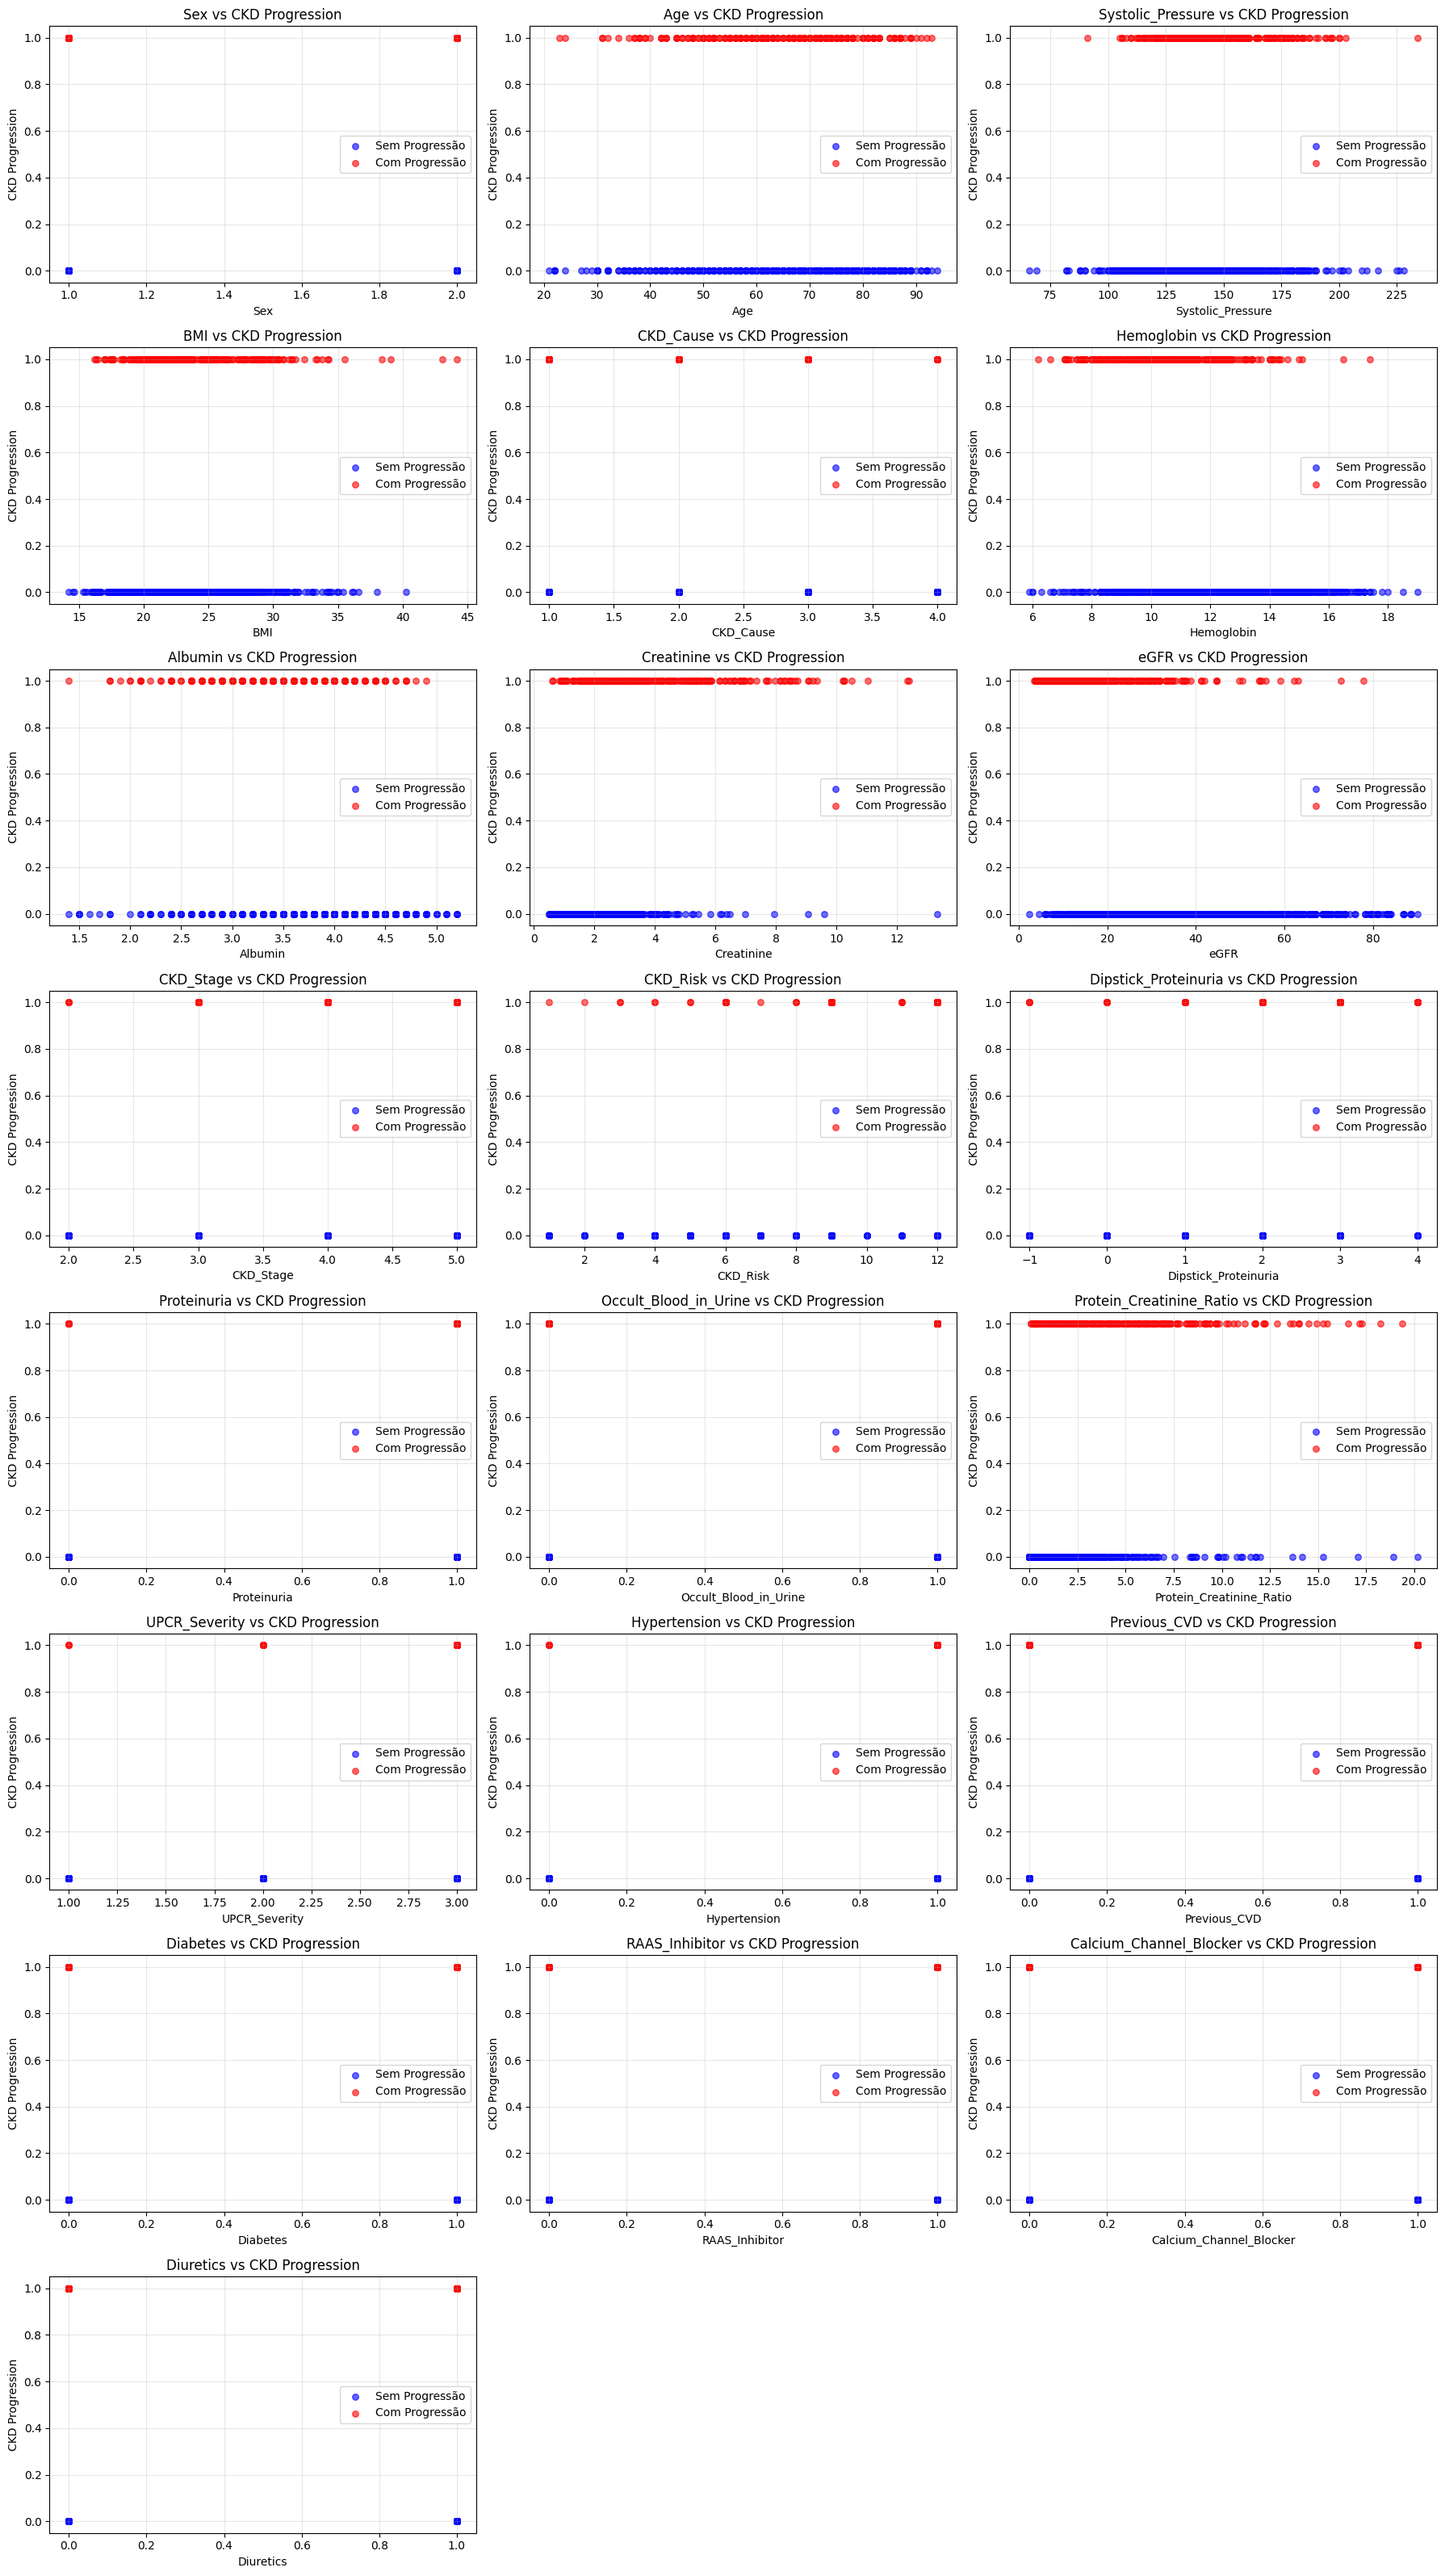

In [81]:
# Gráfico de dispersão MELHORADO para CKD_Progression com cores diferentes
import numpy as np

cols = [col for col in df.columns if col != 'CKD_Progression']
n_cols = 3
n_rows = math.ceil(len(cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, column in enumerate(cols):
    # Separar dados por classe
    no_progression = df[df['CKD_Progression'] == 0]
    progression = df[df['CKD_Progression'] == 1]
    
    # Plotar com cores diferentes
    axes[i].scatter(no_progression[column], no_progression['CKD_Progression'], 
                    alpha=0.6, color='blue', label='Sem Progressão', s=30)
    axes[i].scatter(progression[column], progression['CKD_Progression'], 
                    alpha=0.6, color='red', label='Com Progressão', s=30)
    
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('CKD Progression')
    axes[i].set_title(f'{column} vs CKD Progression')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Remove eixos extras
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

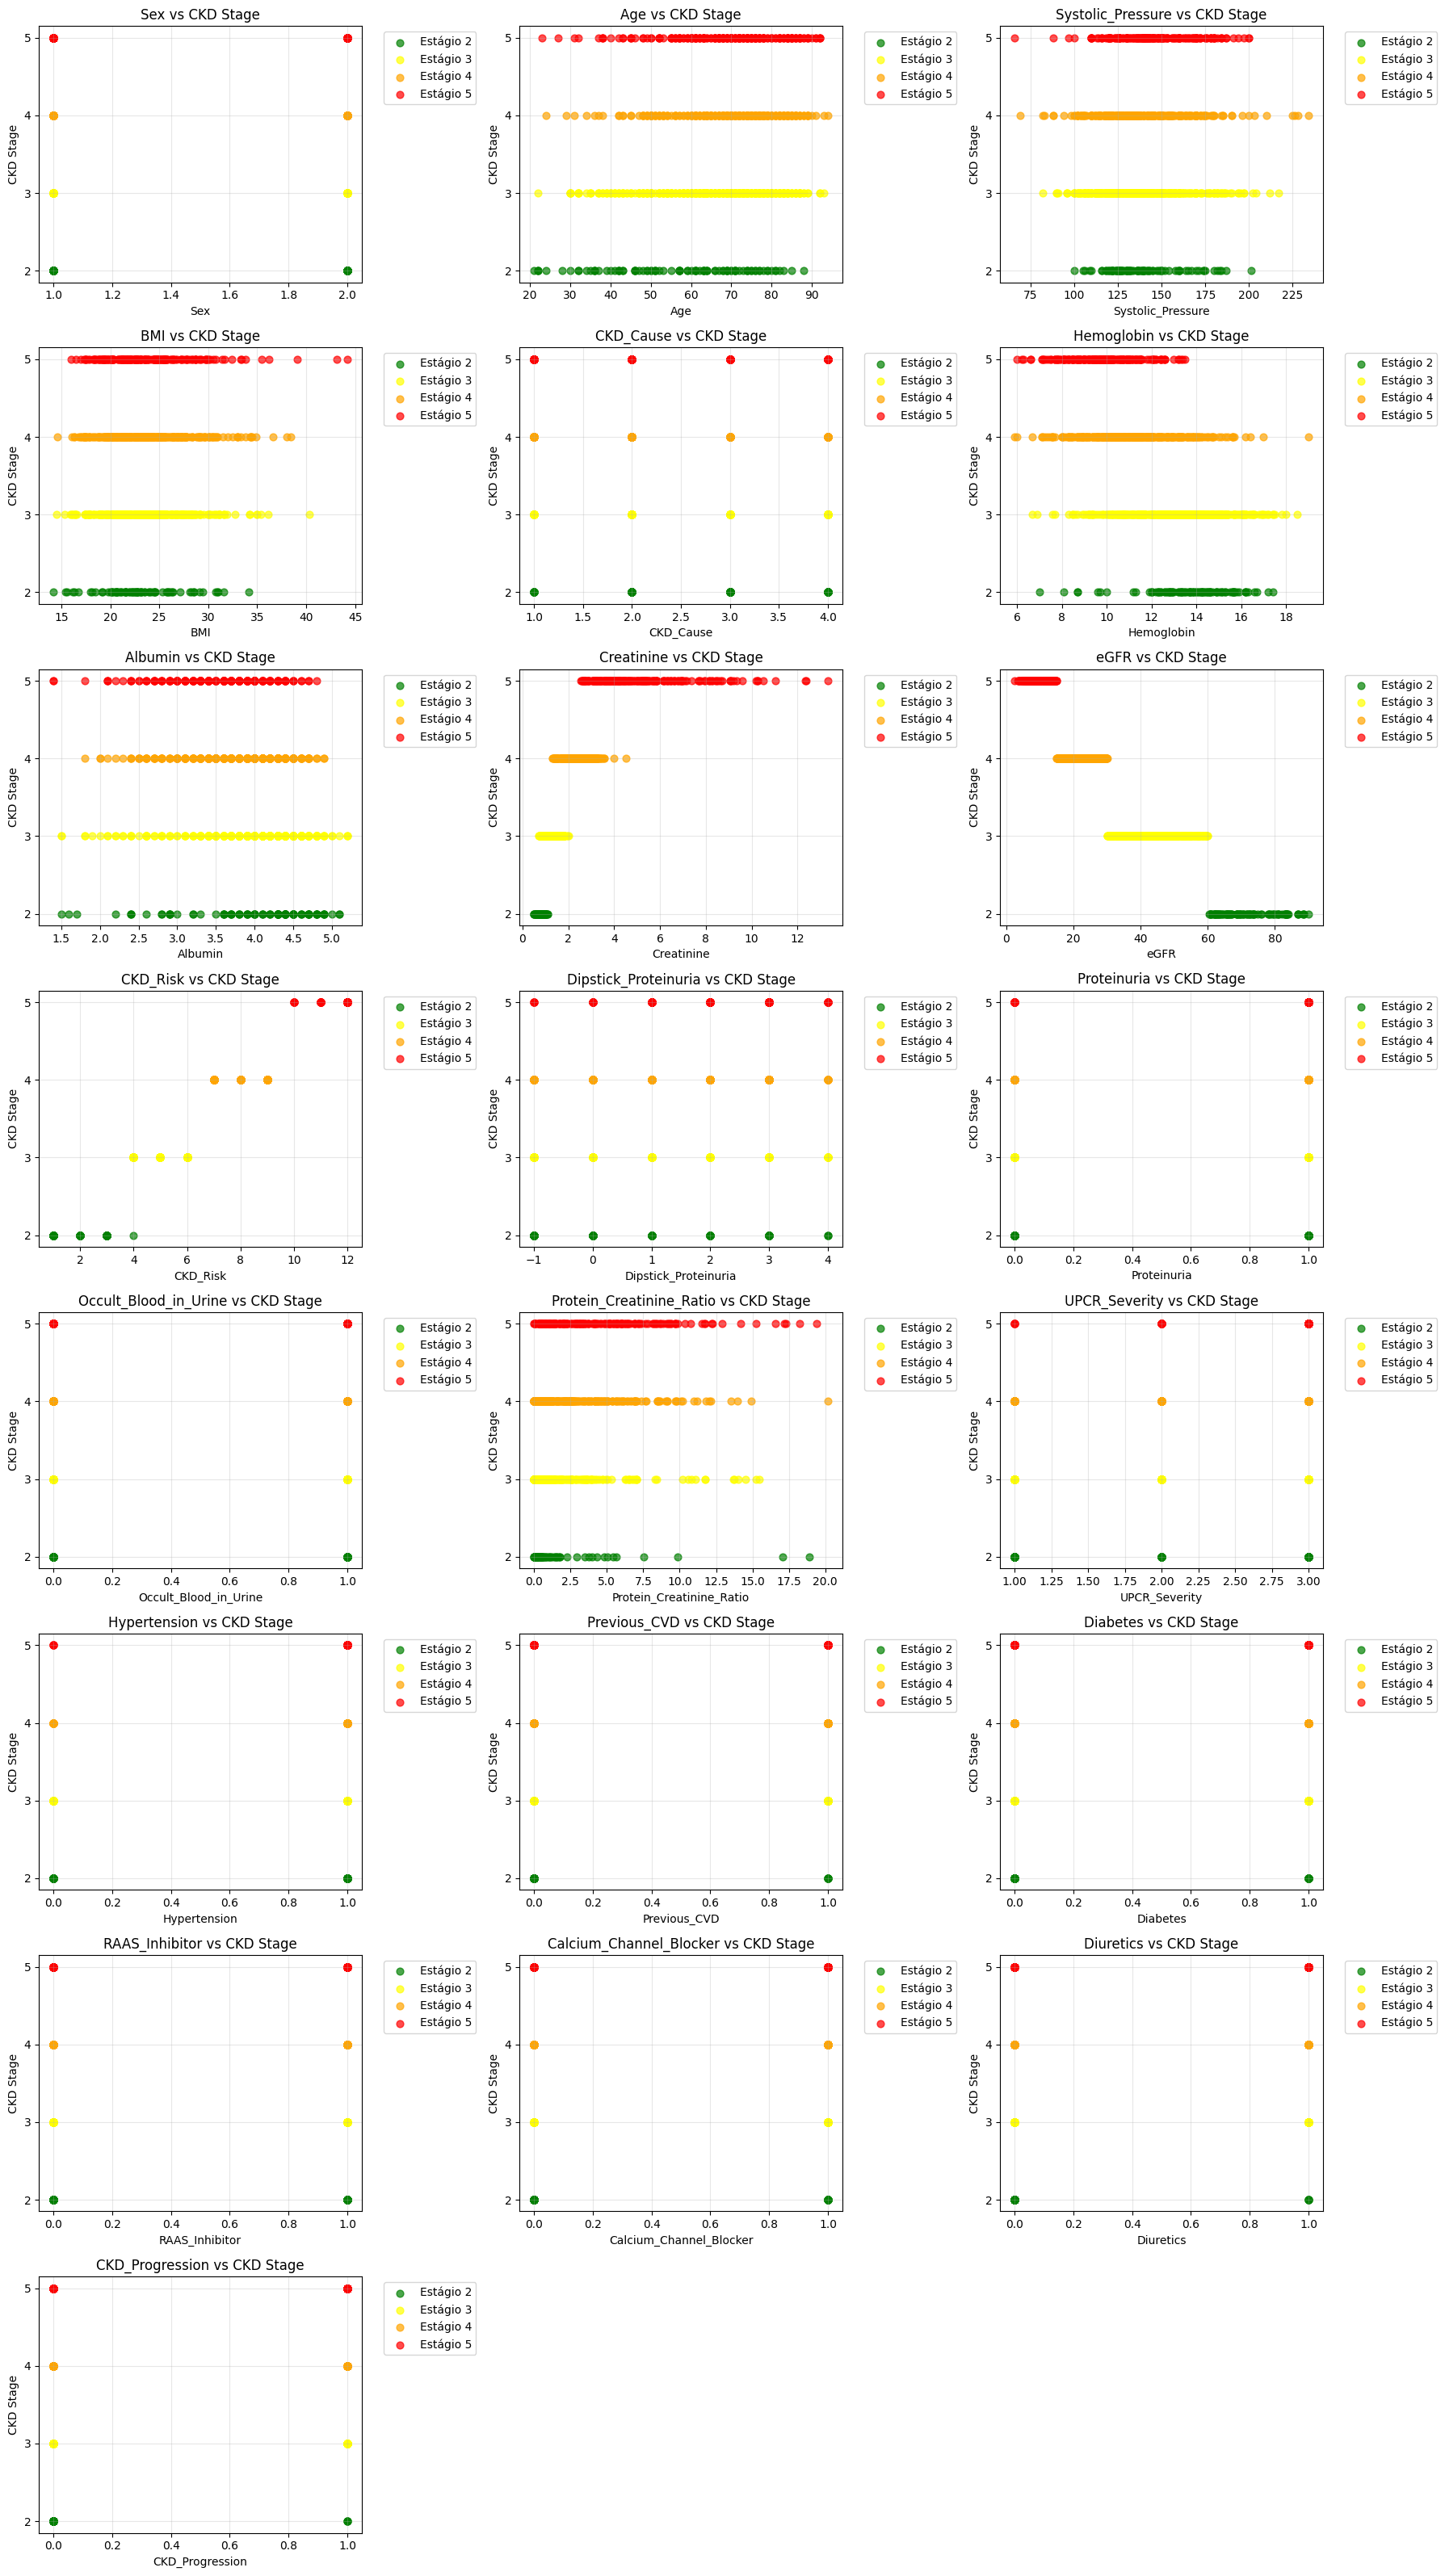

In [82]:
# Gráfico de dispersão para CKD_Stage com cores diferentes
cols = [col for col in df.columns if col != 'CKD_Stage']
n_cols = 3
n_rows = math.ceil(len(cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Cores diferentes para cada estágio
colors = ['green', 'yellow', 'orange', 'red']
stage_labels = ['Estágio 2', 'Estágio 3', 'Estágio 4', 'Estágio 5']

for i, column in enumerate(cols):
    # Plotar cada estágio com cor diferente
    for stage in sorted(df['CKD_Stage'].unique()):
        stage_data = df[df['CKD_Stage'] == stage]
        if len(stage_data) > 0:
            axes[i].scatter(stage_data[column], stage_data['CKD_Stage'], 
                          alpha=0.7, color=colors[stage-2], 
                          label=stage_labels[stage-2], s=40)

    axes[i].set_xlabel(column)
    axes[i].set_ylabel('CKD Stage')
    axes[i].set_title(f'{column} vs CKD Stage')
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_yticks([2, 3, 4, 5])  # Garantir que mostra todos os estágios

# Remove eixos extras se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Histogramas:

Histogramas são gráficos que mostram a distribuição de frequências de uma variável numérica. Eles permitem visualizar como os valores de uma variável se distribuem ao longo de intervalos (bins), facilitando a identificação de padrões, assimetrias, outliers e possíveis agrupamentos nos dados.

**Principais pontos sobre histogramas:**
- O eixo X representa os intervalos de valores (bins) da variável.
- O eixo Y mostra a quantidade (frequência) de observações em cada intervalo.
- Permitem comparar a distribuição de uma variável entre diferentes grupos (ex: pacientes com e sem progressão da doença).
- São úteis para detectar desvios, valores extremos e a forma geral da distribuição (normal, assimétrica, bimodal, etc).

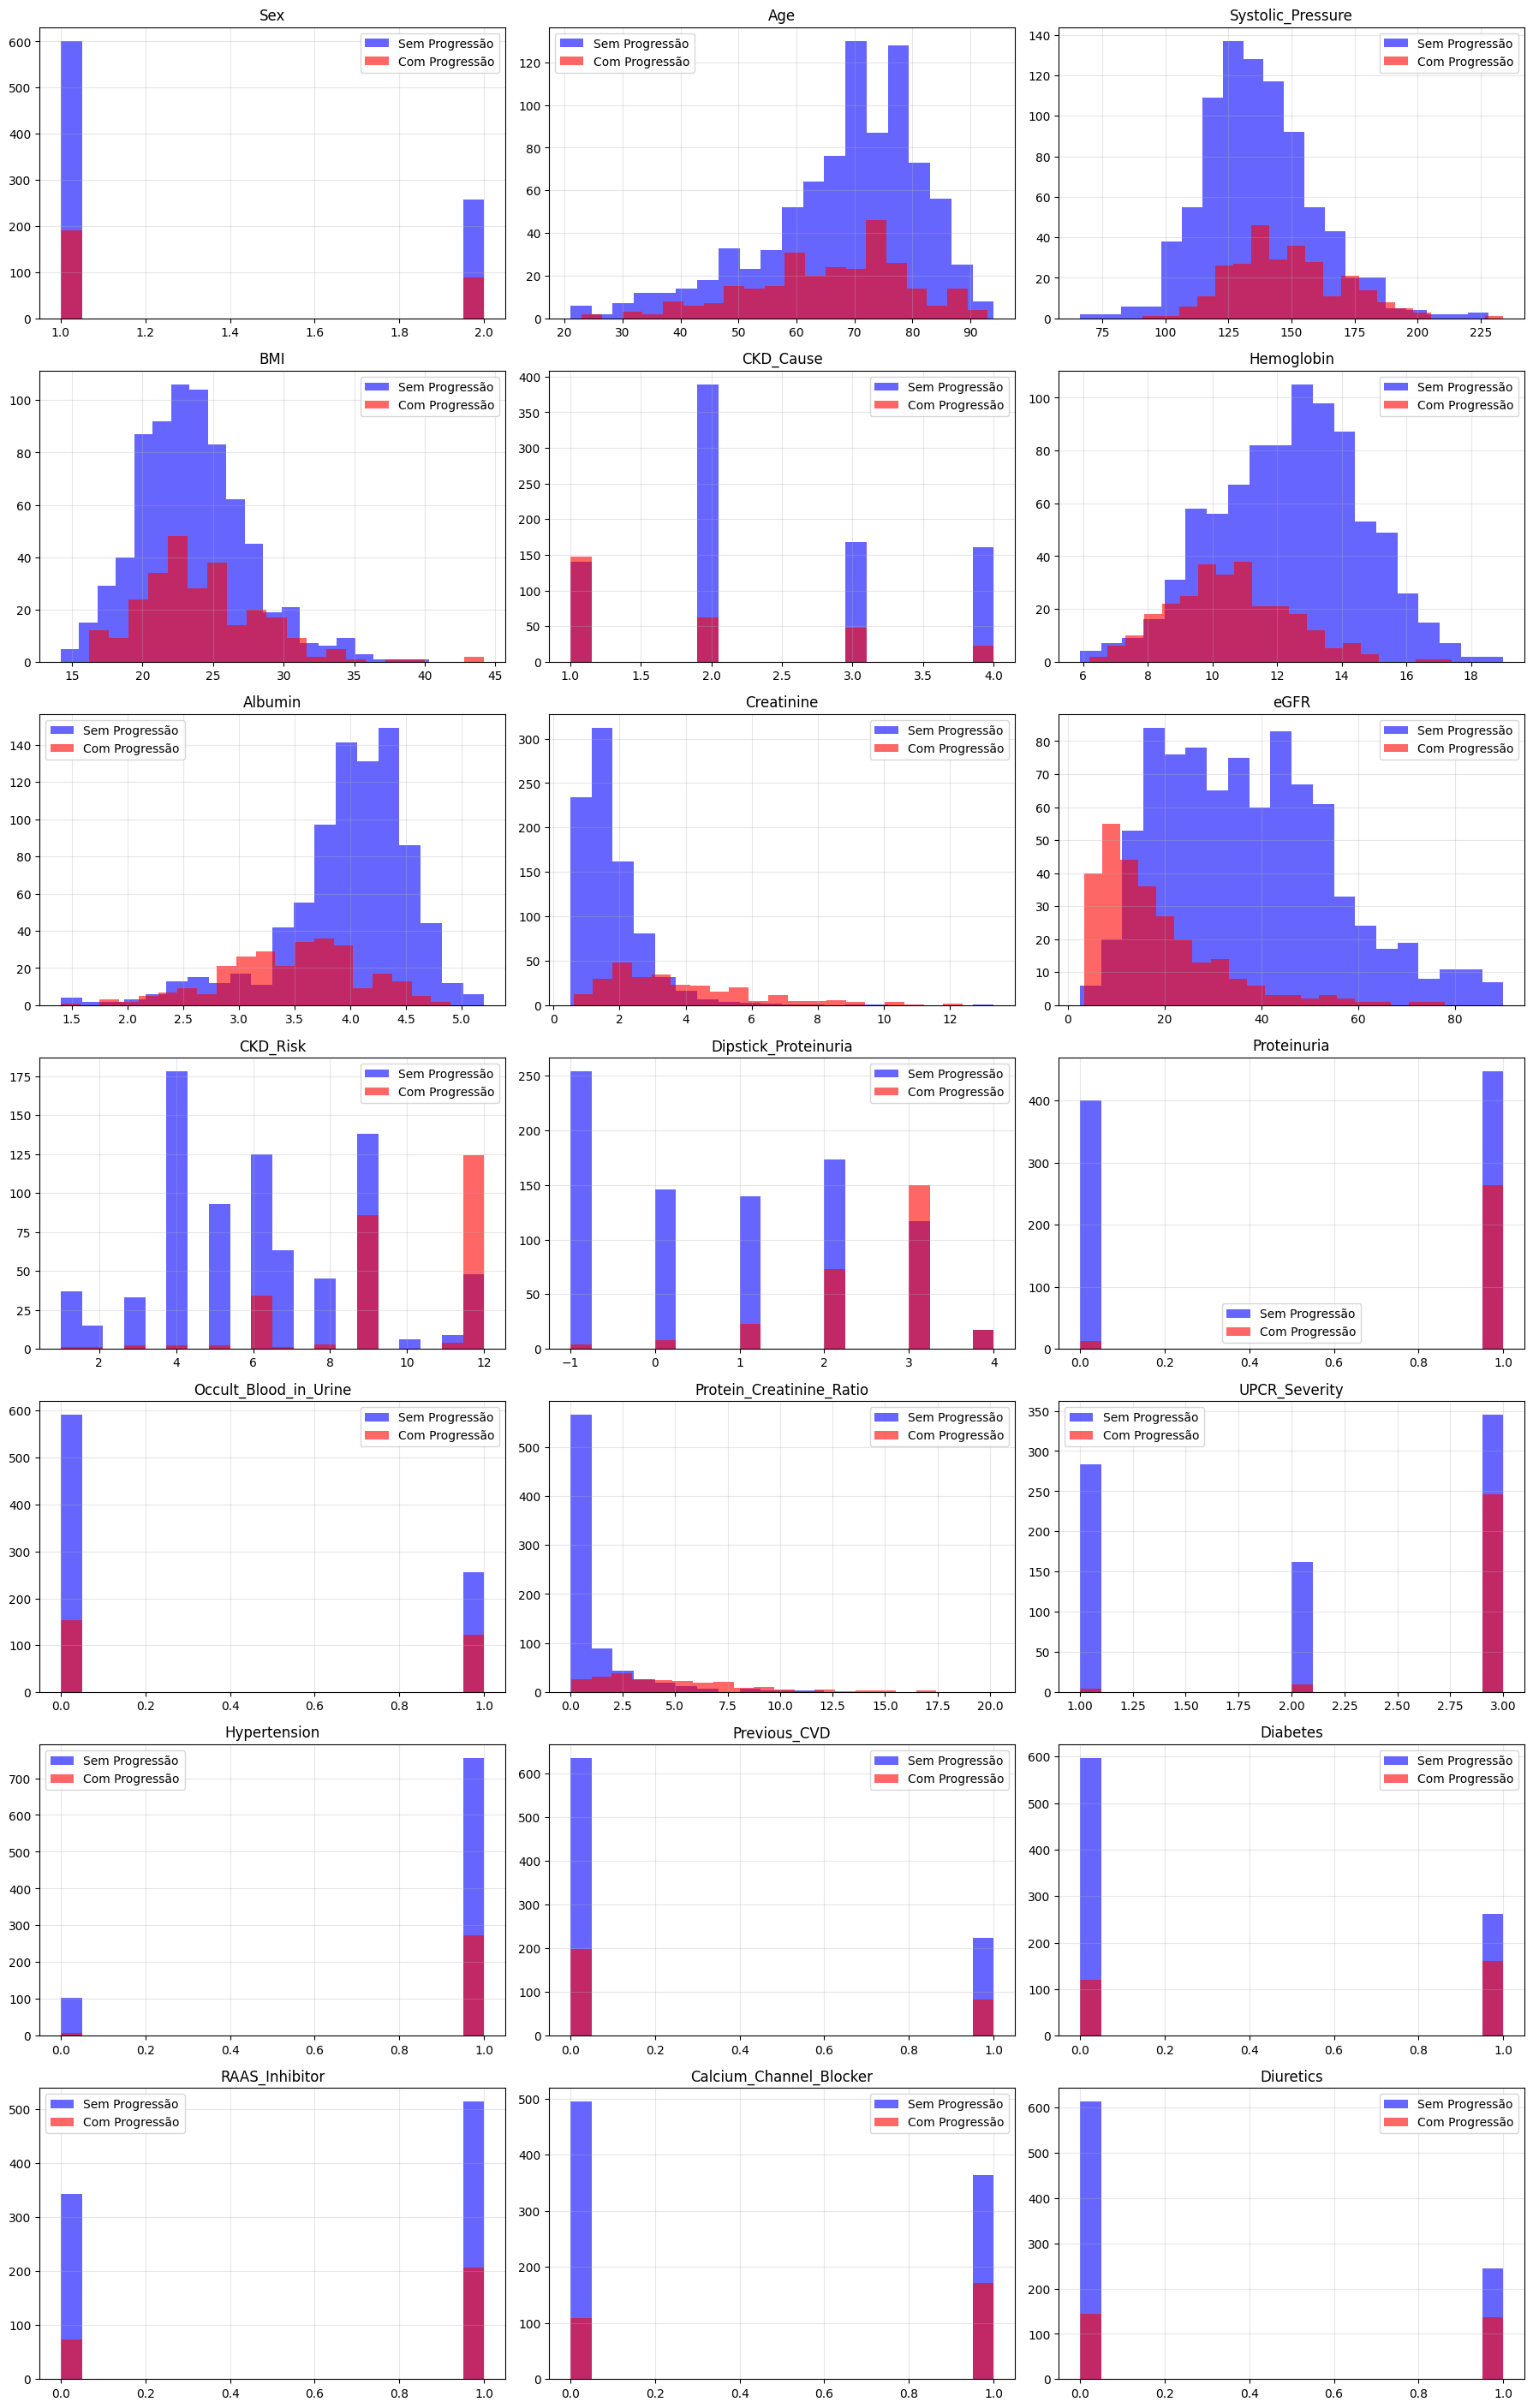

In [25]:
# Plotar histogramas para cada variável em cols, separados por CKD_Progression
n_cols = 3
n_rows = math.ceil(len(cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(cols[:-1]):
	if col == 'CKD_Progression':
		continue  # Não faz sentido plotar histograma da variável alvo
	# Remover valores nulos para cada grupo
	data0 = df[df['CKD_Progression'] == 0][col].dropna()
	data1 = df[df['CKD_Progression'] == 1][col].dropna()
	axes[idx].hist(data0, bins=20, alpha=0.6, label='Sem Progressão', color='blue')
	axes[idx].hist(data1, bins=20, alpha=0.6, label='Com Progressão', color='red')
	axes[idx].set_title(col)
	axes[idx].legend()
	axes[idx].grid(True, alpha=0.3)

# Remove eixos extras
for j in range(idx + 1, len(axes)):
	fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

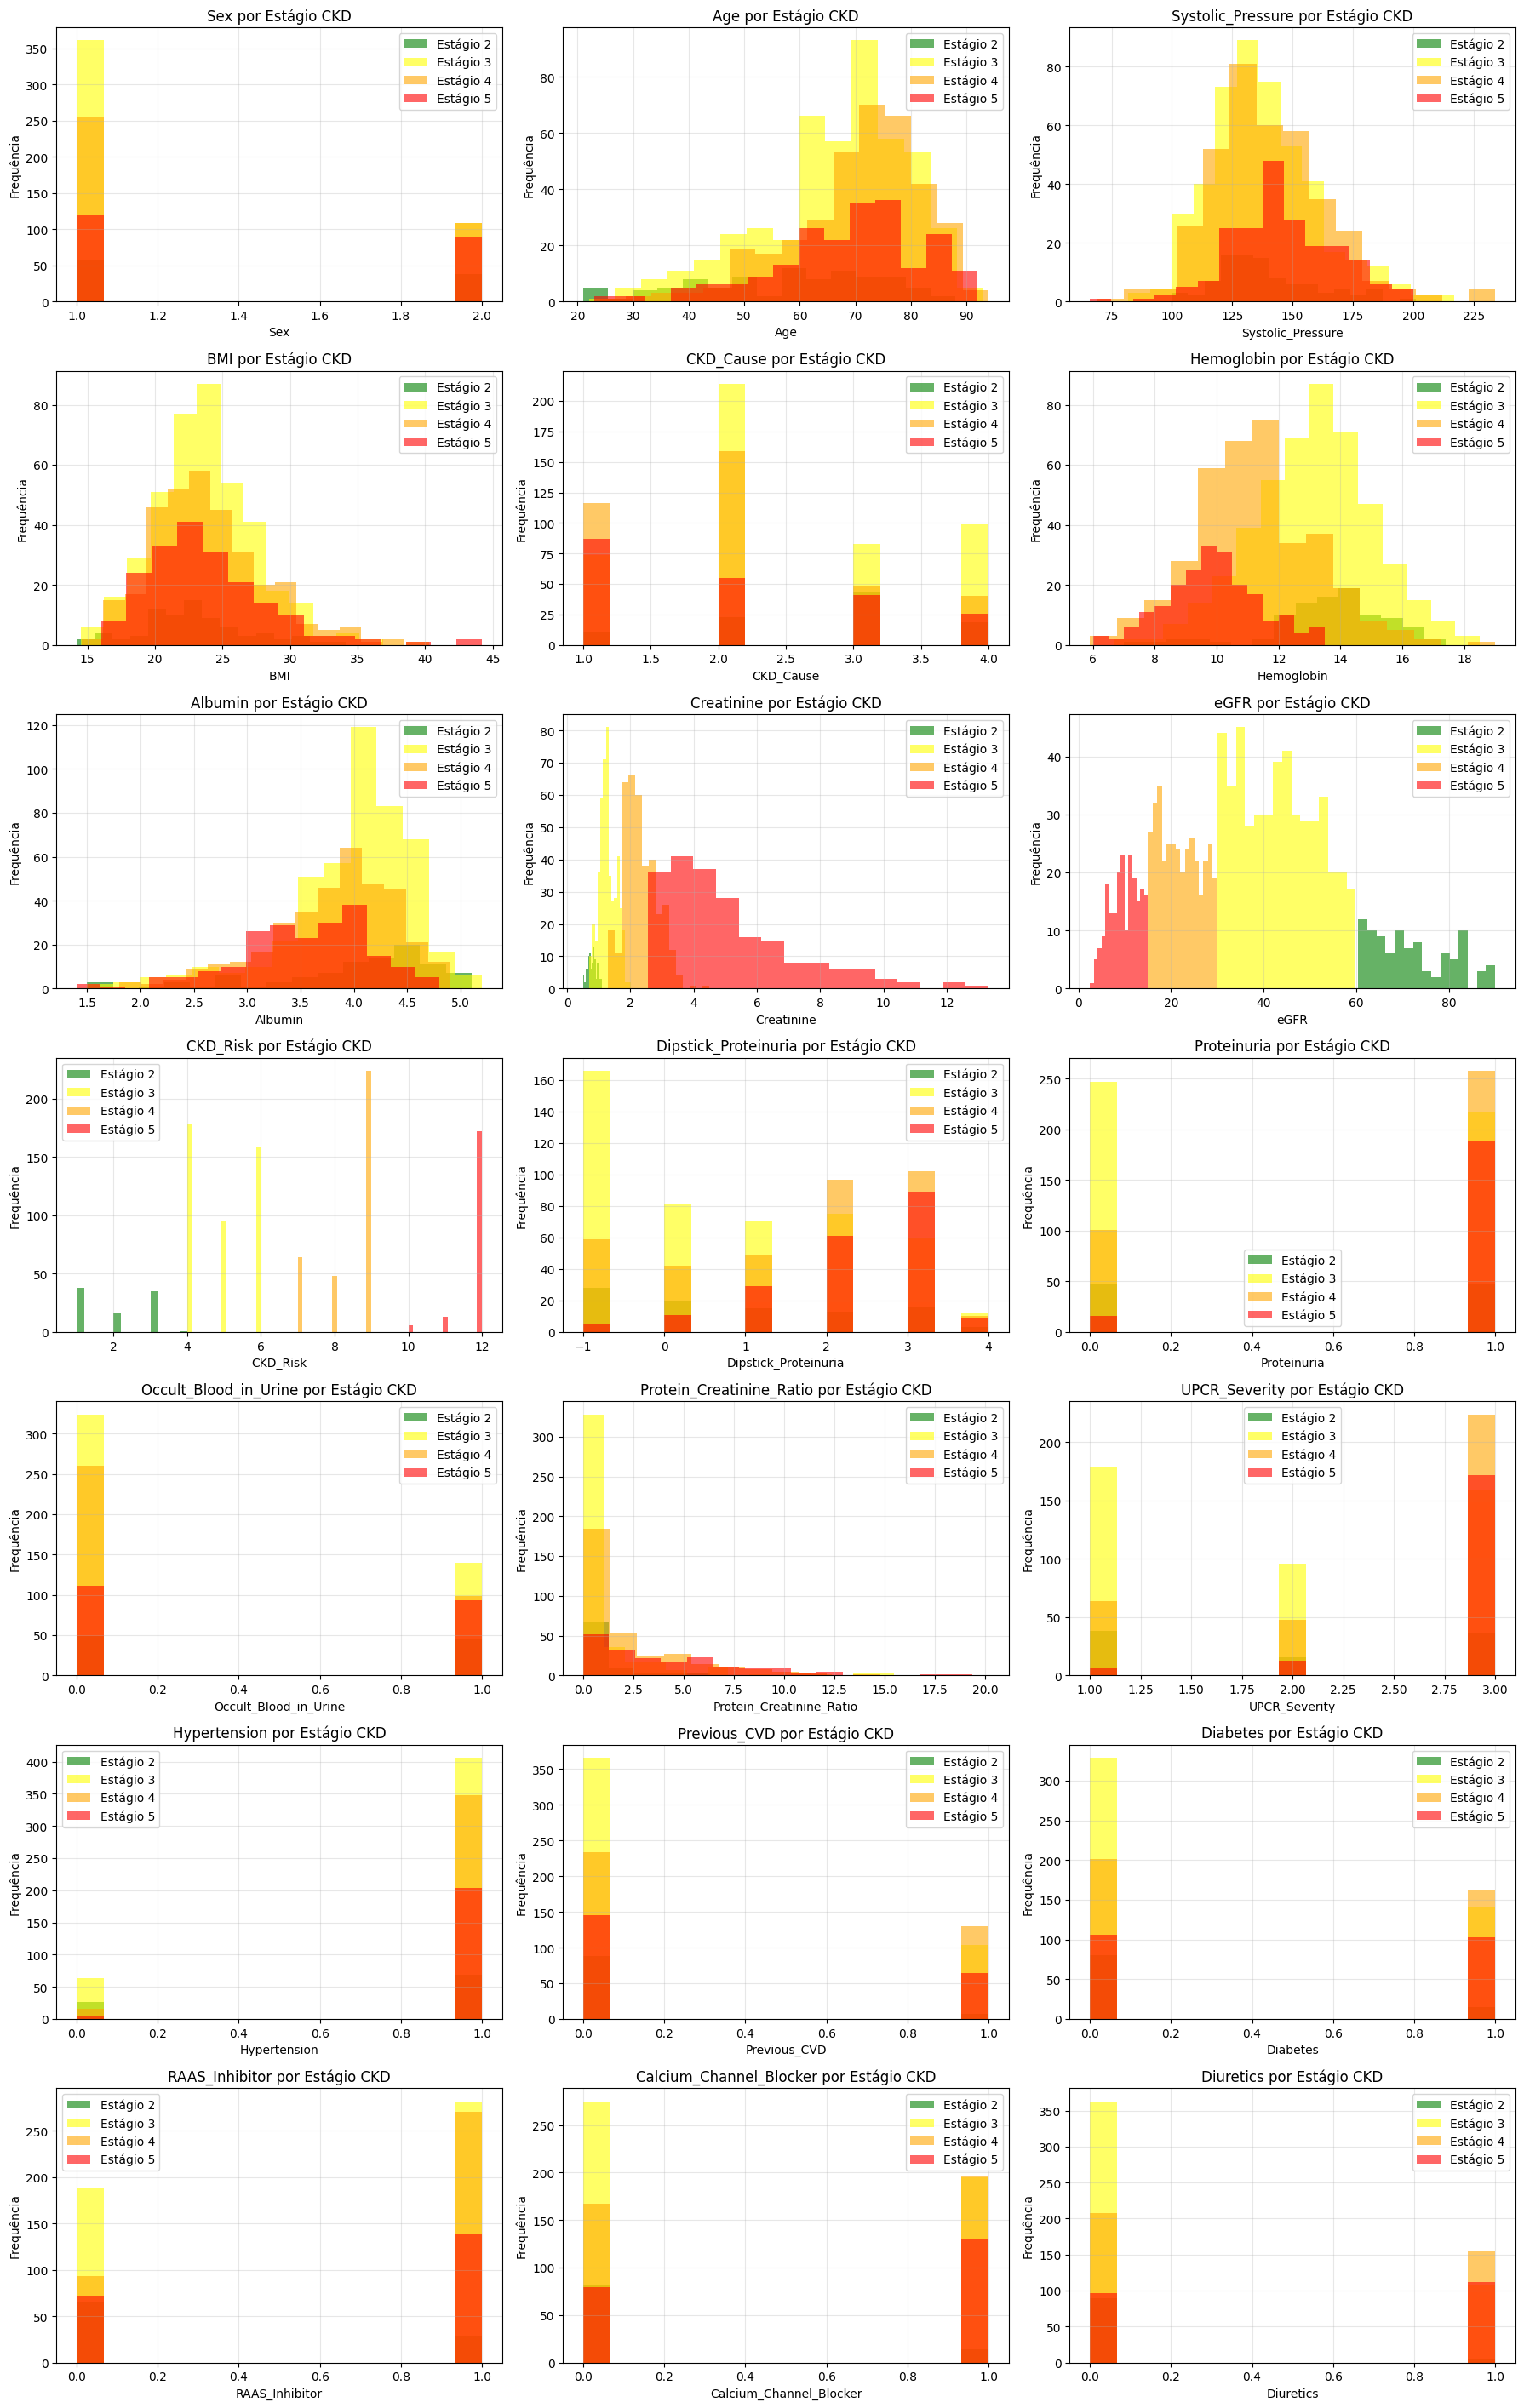

In [83]:
# Plotar histogramas para cada variável separados por CKD_Stage (CORRIGIDO)
cols_without_stage = [col for col in df.columns if col != 'CKD_Stage']
n_cols = 3
n_rows = math.ceil(len(cols_without_stage) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Cores para cada estágio
stage_colors = {2: 'green', 3: 'yellow', 4: 'orange', 5: 'red'}
stage_labels = {2: 'Estágio 2', 3: 'Estágio 3', 4: 'Estágio 4', 5: 'Estágio 5'}

for idx, col in enumerate(cols_without_stage[:-1]):
    if col == 'CKD_Progression':
        continue  # Pular a outra variável alvo
    
    # Plotar histograma para cada estágio
    for stage in sorted(df['CKD_Stage'].unique()):
        data_stage = df[df['CKD_Stage'] == stage][col].dropna()
        if len(data_stage) > 0:  # Só plotar se houver dados
            axes[idx].hist(data_stage, bins=15, alpha=0.6, 
                          label=stage_labels[stage], 
                          color=stage_colors[stage])
    
    axes[idx].set_title(f'{col} por Estágio CKD')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequência')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Remove eixos extras
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Correlações:

#### Interpretação dos coeficientes de correlação

Os valores do coeficiente de correlação variam entre -1 e +1:

- **+1**: Correlação positiva perfeita (as variáveis aumentam juntas)
- **-1**: Correlação negativa perfeita (uma variável aumenta enquanto a outra diminui)
- **0**: Sem correlação linear

**Força da correlação:**
- **±0.7 a ±1.0**: Correlação forte
- **±0.3 a ±0.7**: Correlação moderada
- **±0.0 a ±0.3**: Correlação fraca

> **Observação:**  
> Correlação não implica causalidade. Mesmo que duas variáveis apresentem correlação forte, isso não significa que uma causa a outra.  
> Além disso, o coeficiente de correlação de Pearson avalia apenas relações lineares. Relações não-lineares podem não ser detectadas por esse método.

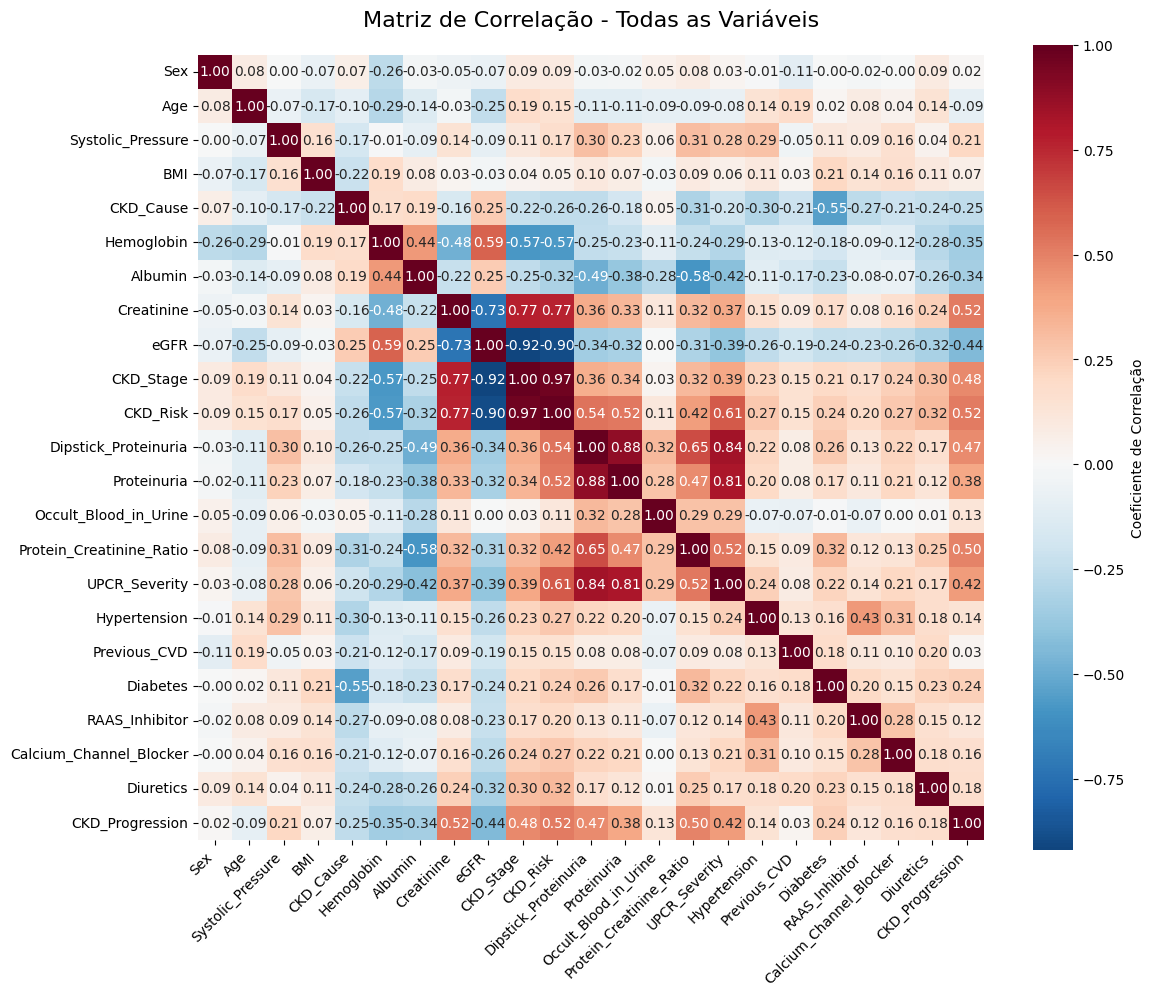

In [84]:
# Matriz de correlação de todas as variáveis numéricas
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 10))
correlation_matrix = numeric_df.corr()

# Heatmap de correlação
sns.heatmap(correlation_matrix, 
            annot=True,           # Mostrar valores
            cmap='RdBu_r',        # Cores: vermelho=positiva, azul=negativa
            center=0,             # Centro em 0
            square=True,          # Células quadradas
            fmt='.2f',            # 2 casas decimais
            cbar_kws={'label': 'Coeficiente de Correlação'})

plt.title('Matriz de Correlação - Todas as Variáveis', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [85]:
# Correlações específicas com as variáveis alvo
print("=== CORRELAÇÕES COM CKD_PROGRESSION ===")
target_corr_prog = correlation_matrix['CKD_Progression'].sort_values(key=abs, ascending=False)
print(target_corr_prog)

print("\n=== CORRELAÇÕES COM CKD_STAGE ===")
target_corr_stage = correlation_matrix['CKD_Stage'].sort_values(key=abs, ascending=False)
print(target_corr_stage)

print("\n=== ANÁLISE DAS CORRELAÇÕES ===")
print("🔍 Correlações FORTES com CKD_Progression (>0.3):")
strong_prog = target_corr_prog[abs(target_corr_prog) > 0.3]
for var, corr in strong_prog.items():
    if var != 'CKD_Progression':
        direction = "positiva" if corr > 0 else "negativa"
        print(f"   {var}: {corr:.3f} ({direction})")

print("\n🔍 Correlações FORTES com CKD_Stage (>0.3):")
strong_stage = target_corr_stage[abs(target_corr_stage) > 0.3]
for var, corr in strong_stage.items():
    if var != 'CKD_Stage':
        direction = "positiva" if corr > 0 else "negativa"
        print(f"   {var}: {corr:.3f} ({direction})")

=== CORRELAÇÕES COM CKD_PROGRESSION ===
CKD_Progression             1.000000
Creatinine                  0.519546
CKD_Risk                    0.519427
Protein_Creatinine_Ratio    0.496221
CKD_Stage                   0.475472
Dipstick_Proteinuria        0.469856
eGFR                       -0.442793
UPCR_Severity               0.424114
Proteinuria                 0.382473
Hemoglobin                 -0.346122
Albumin                    -0.335144
CKD_Cause                  -0.254608
Diabetes                    0.237247
Systolic_Pressure           0.208264
Diuretics                   0.182685
Calcium_Channel_Blocker     0.163981
Hypertension                0.139671
Occult_Blood_in_Urine       0.128678
RAAS_Inhibitor              0.122086
Age                        -0.087465
BMI                         0.066758
Previous_CVD                0.032041
Sex                         0.017156
Name: CKD_Progression, dtype: float64

=== CORRELAÇÕES COM CKD_STAGE ===
CKD_Stage                   1.000000

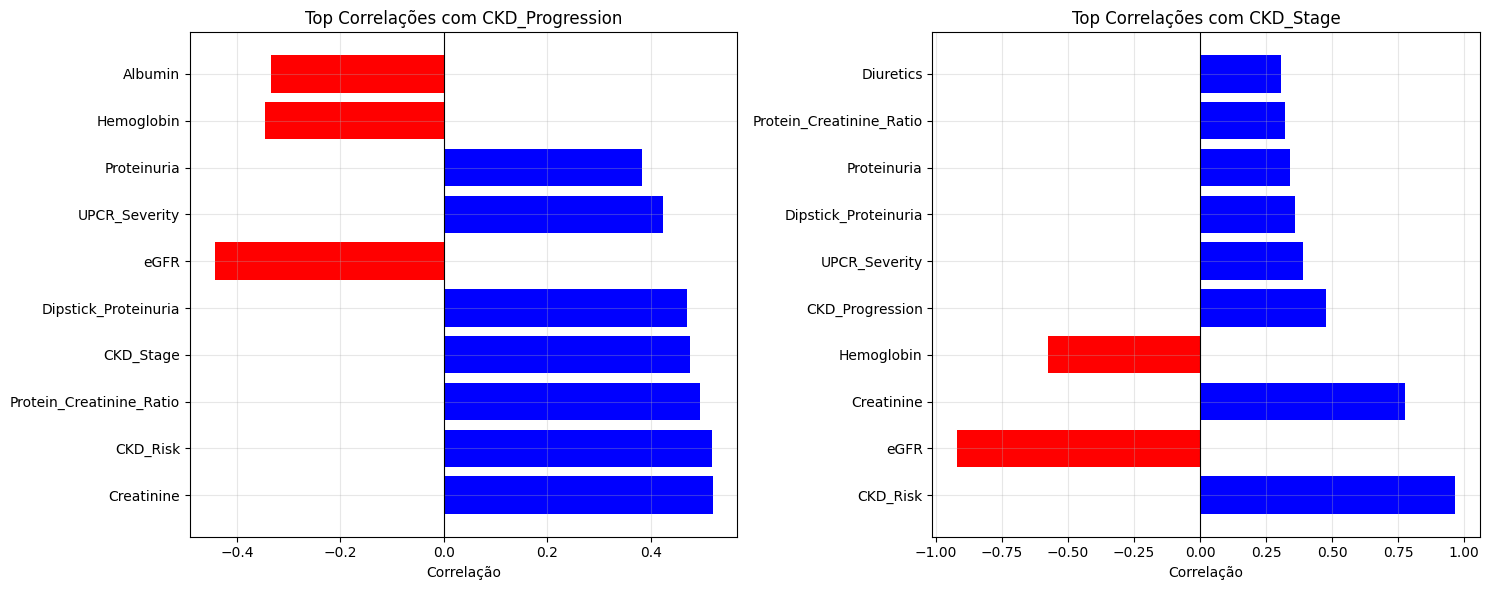

In [86]:
# Gráfico de barras das correlações mais importantes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Correlações com CKD_Progression (excluindo ela mesma)
prog_corr = target_corr_prog.drop('CKD_Progression')
top_prog = prog_corr.head(10)  # Top 10

ax1.barh(range(len(top_prog)), top_prog.values, 
         color=['red' if x < 0 else 'blue' for x in top_prog.values])
ax1.set_yticks(range(len(top_prog)))
ax1.set_yticklabels(top_prog.index)
ax1.set_xlabel('Correlação')
ax1.set_title('Top Correlações com CKD_Progression')
ax1.grid(True, alpha=0.3)
ax1.axvline(0, color='black', linewidth=0.8)

# Correlações com CKD_Stage (excluindo ela mesma)
stage_corr = target_corr_stage.drop('CKD_Stage')
top_stage = stage_corr.head(10)  # Top 10

ax2.barh(range(len(top_stage)), top_stage.values,
         color=['red' if x < 0 else 'blue' for x in top_stage.values])
ax2.set_yticks(range(len(top_stage)))
ax2.set_yticklabels(top_stage.index)
ax2.set_xlabel('Correlação')
ax2.set_title('Top Correlações com CKD_Stage')
ax2.grid(True, alpha=0.3)
ax2.axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

## Outliers:

#### 1. Método IQR (Interquartile Range) - Quartis


**Como funciona:**
- Calcula Q1 (25º percentil) e Q3 (75º percentil)
- IQR = Q3 - Q1
- Outliers: valores < Q1 - 1.5×IQR ou > Q3 + 1.5×IQR

**Vantagens:**
- Robusto para dados assimétricos
- Não assume distribuição normal
- Fácil interpretação

**Desvantagens:**
- Pode ser conservador (detecta poucos outliers)

---

In [87]:
## Detecção de Outliers

### Método 1: IQR (Interquartile Range)
print("=== DETECÇÃO DE OUTLIERS - MÉTODO IQR ===\n")

def detect_outliers_iqr(df, column):
    """Detecta outliers usando o método IQR"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Limites para outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identificar outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers, lower_bound, upper_bound

# Analisar cada variável numérica
numeric_columns = df.select_dtypes(include=[np.number]).columns

outlier_summary = {}
for col in numeric_columns:
    outliers, lower, upper = detect_outliers_iqr(df, col)
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df)) * 100
    
    outlier_summary[col] = {
        'count': outlier_count,
        'percentage': outlier_percentage,
        'lower_bound': lower,
        'upper_bound': upper
    }
    
    print(f"📊 {col}:")
    print(f"   Outliers: {outlier_count} ({outlier_percentage:.1f}%)")
    print(f"   Limites: [{lower:.2f}, {upper:.2f}]")
    if outlier_count > 0:
        print(f"   Valores extremos: {outliers[col].min():.2f} a {outliers[col].max():.2f}")
    print()

=== DETECÇÃO DE OUTLIERS - MÉTODO IQR ===

📊 Sex:
   Outliers: 0 (0.0%)
   Limites: [-0.50, 3.50]

📊 Age:
   Outliers: 37 (3.3%)
   Limites: [37.00, 101.00]
   Valores extremos: 21.00 a 36.00

📊 Systolic_Pressure:
   Outliers: 27 (2.4%)
   Limites: [84.50, 192.50]
   Valores extremos: 66.00 a 234.00

📊 BMI:
   Outliers: 26 (2.3%)
   Limites: [13.80, 33.00]
   Valores extremos: 33.30 a 44.20

📊 CKD_Cause:
   Outliers: 0 (0.0%)
   Limites: [-2.00, 6.00]

📊 Hemoglobin:
   Outliers: 1 (0.1%)
   Limites: [5.10, 18.70]
   Valores extremos: 19.00 a 19.00

📊 Albumin:
   Outliers: 30 (2.6%)
   Limites: [2.30, 5.50]
   Valores extremos: 1.40 a 2.30

📊 Creatinine:
   Outliers: 89 (7.8%)
   Limites: [-1.02, 4.90]
   Valores extremos: 4.95 a 13.32

📊 eGFR:
   Outliers: 7 (0.6%)
   Limites: [-23.71, 86.18]
   Valores extremos: 86.78 a 89.98

📊 CKD_Stage:
   Outliers: 0 (0.0%)
   Limites: [1.50, 5.50]

📊 CKD_Risk:
   Outliers: 0 (0.0%)
   Limites: [-3.50, 16.50]

📊 Dipstick_Proteinuria:
   Outliers: 

#### 2. Método Z-Score - Desvio Padrão

**Como funciona:**
- Calcula quantos desvios padrão cada valor está da média
- Z = (valor - média) / desvio padrão
- Outliers: |Z| > 3 (padrão)

**Vantagens:**
- Sensível a valores extremos
- Padrão estatístico bem estabelecido

**Desvantagens:**
- Assume distribuição normal
- Sensível a outliers extremos

---

In [88]:
### Método 2: Z-Score
print("=== DETECÇÃO DE OUTLIERS - MÉTODO Z-SCORE ===\n")

def detect_outliers_zscore(df, column, threshold=3):
    """Detecta outliers usando Z-Score (padrão: |z| > 3)"""
    z_scores = np.abs(stats.zscore(df[column].dropna()))
    outliers_idx = np.where(z_scores > threshold)[0]
    return outliers_idx, z_scores

for col in numeric_columns:
    outliers_idx, z_scores = detect_outliers_zscore(df, col)
    outlier_count = len(outliers_idx)
    outlier_percentage = (outlier_count / len(df)) * 100
    
    print(f"📊 {col}:")
    print(f"   Outliers Z-Score: {outlier_count} ({outlier_percentage:.1f}%)")
    if outlier_count > 0:
        max_z = z_scores.max()
        print(f"   Z-Score máximo: {max_z:.2f}")
    print()

=== DETECÇÃO DE OUTLIERS - MÉTODO Z-SCORE ===

📊 Sex:
   Outliers Z-Score: 0 (0.0%)

📊 Age:
   Outliers Z-Score: 8 (0.7%)
   Z-Score máximo: 3.41

📊 Systolic_Pressure:
   Outliers Z-Score: 9 (0.8%)
   Z-Score máximo: 4.20

📊 BMI:
   Outliers Z-Score: 9 (0.8%)
   Z-Score máximo: 5.08

📊 CKD_Cause:
   Outliers Z-Score: 0 (0.0%)

📊 Hemoglobin:
   Outliers Z-Score: 1 (0.1%)
   Z-Score máximo: 3.08

📊 Albumin:
   Outliers Z-Score: 12 (1.1%)
   Z-Score máximo: 3.84

📊 Creatinine:
   Outliers Z-Score: 28 (2.5%)
   Z-Score máximo: 6.44

📊 eGFR:
   Outliers Z-Score: 1 (0.1%)
   Z-Score máximo: 3.06

📊 CKD_Stage:
   Outliers Z-Score: 0 (0.0%)

📊 CKD_Risk:
   Outliers Z-Score: 0 (0.0%)

📊 Dipstick_Proteinuria:
   Outliers Z-Score: 0 (0.0%)

📊 Proteinuria:
   Outliers Z-Score: 0 (0.0%)

📊 Occult_Blood_in_Urine:
   Outliers Z-Score: 0 (0.0%)

📊 Protein_Creatinine_Ratio:
   Outliers Z-Score: 24 (2.1%)
   Z-Score máximo: 5.58

📊 UPCR_Severity:
   Outliers Z-Score: 0 (0.0%)

📊 Hypertension:
   Outlier

#### 3. Boxplots - Visualização

**Como funciona:**
- Baseado no método IQR
- Mostra Q1, mediana, Q3 e outliers
- Pontos fora dos "bigodes" são outliers

**Vantagens:**
- Visualização clara
- Mostra distribuição dos dados
- Fácil identificação visual

**Desvantagens:**
- Apenas visualização (não quantifica)

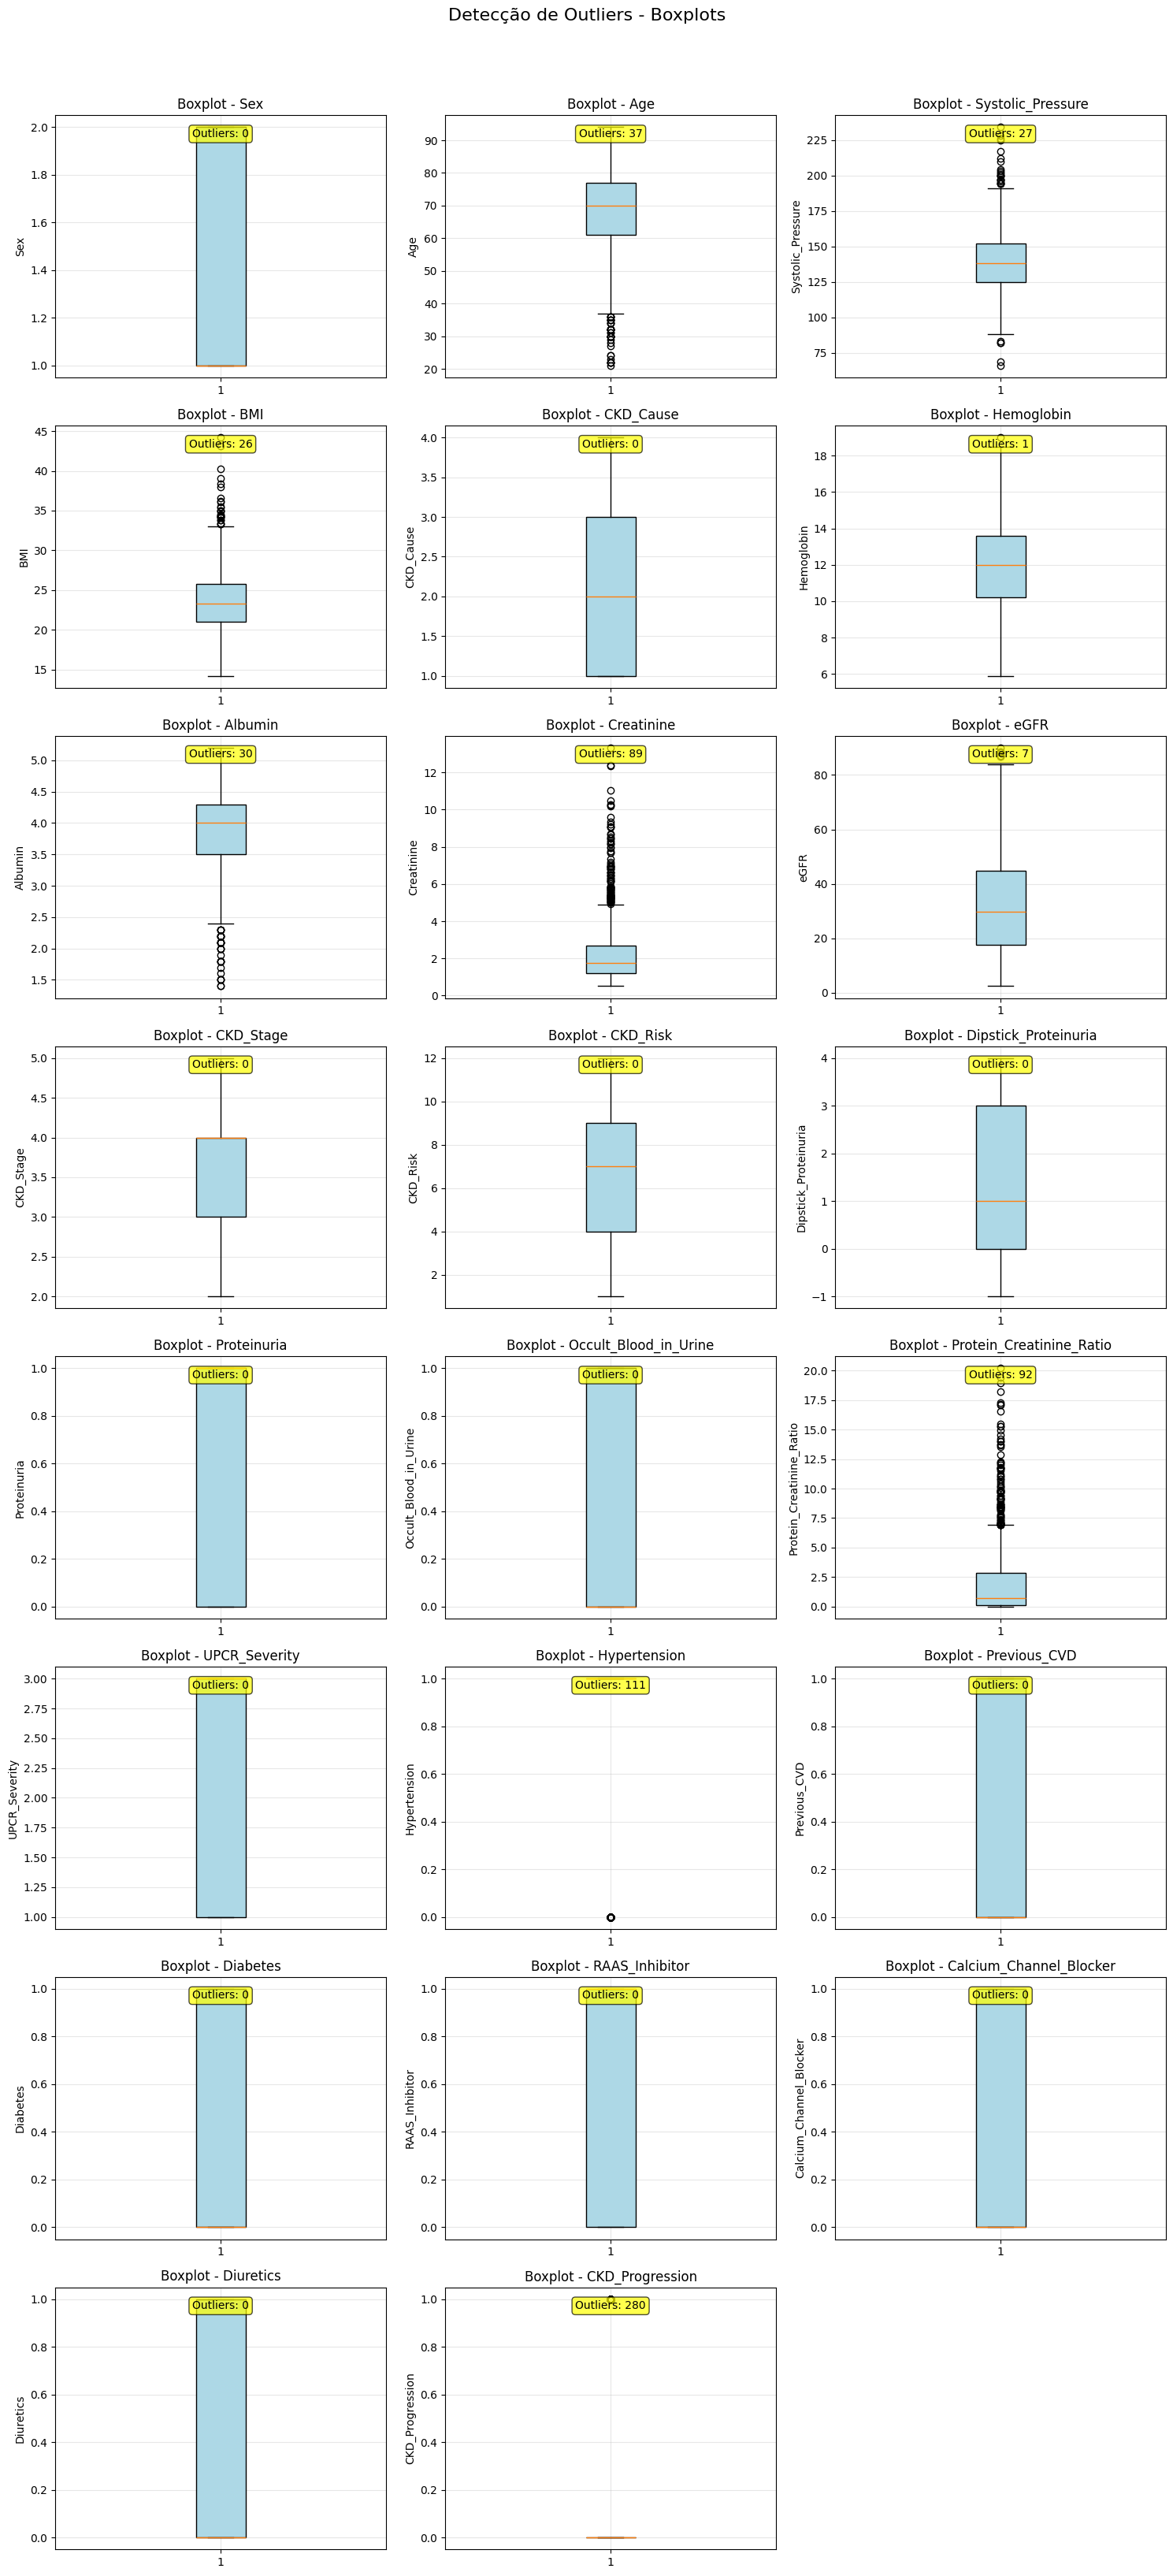

In [89]:
### Método 3: Boxplots para visualizar outliers
n_cols = 3
n_rows = math.ceil(len(numeric_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    # Boxplot
    box_plot = axes[i].boxplot(df[col].dropna(), patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightblue')
    
    axes[i].set_title(f'Boxplot - {col}')
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)
    
    # Adicionar informações sobre outliers
    outliers, lower, upper = detect_outliers_iqr(df, col)
    outlier_count = len(outliers)
    axes[i].text(0.5, 0.95, f'Outliers: {outlier_count}', 
                transform=axes[i].transAxes, ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Remove eixos extras
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Detecção de Outliers - Boxplots', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# 2 - Pré-processamento: 
Tratar valores faltantes. Normalizar ou padronizar atributos quando necessário. Separar o conjunto de dados (sugestão: 70% treino, 15% teste, 15% validação).

In [90]:
# Converter todas as colunas para float64
df = df.astype('float64')

# Preencher valores faltantes com a média de cada coluna
df = df.apply(lambda col: col.fillna(col.mean()), axis=0)

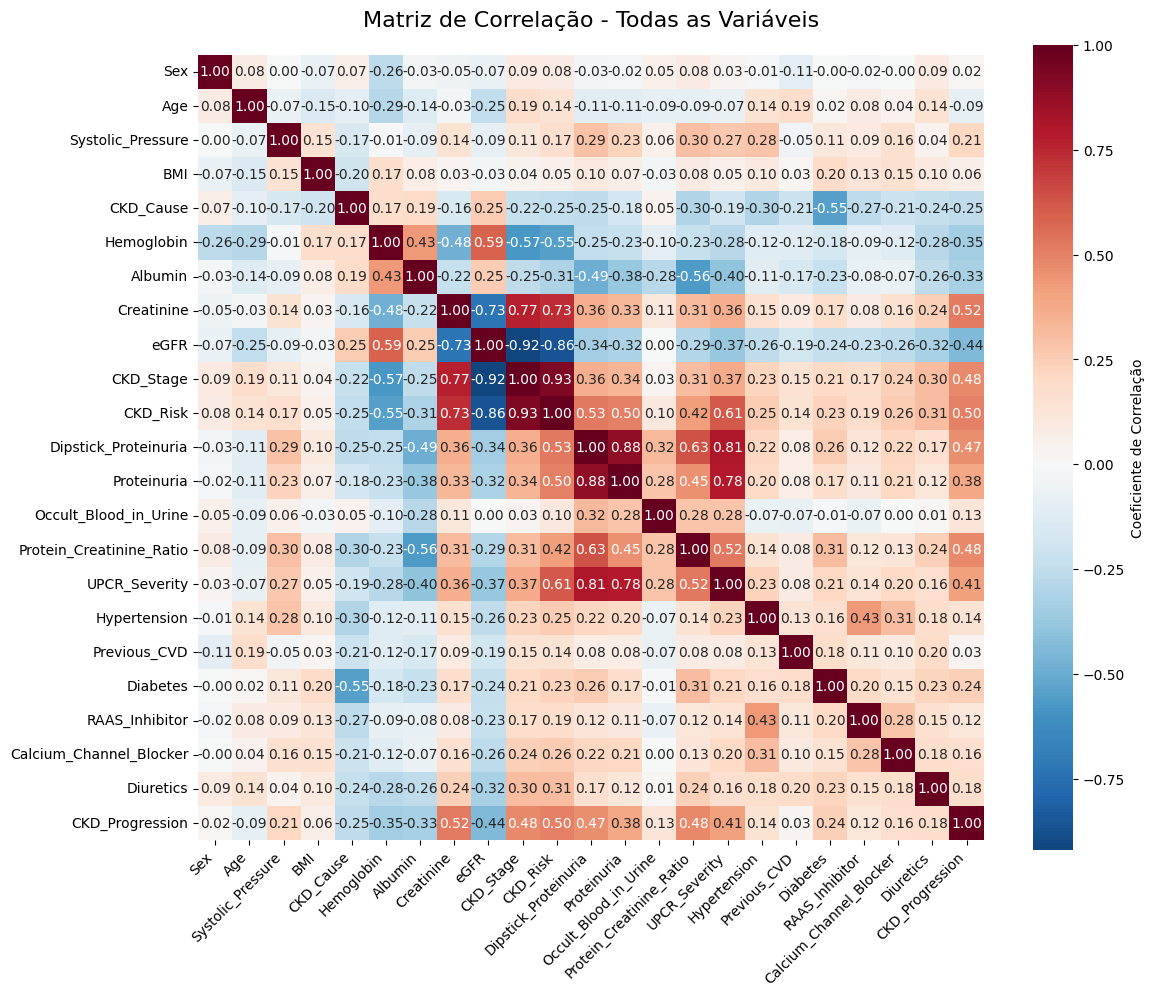

In [91]:
# Matriz de correlação de todas as variáveis numéricas
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 10))
correlation_matrix = numeric_df.corr()

# Heatmap de correlação
sns.heatmap(correlation_matrix, 
            annot=True,           # Mostrar valores
            cmap='RdBu_r',        # Cores: vermelho=positiva, azul=negativa
            center=0,             # Centro em 0
            square=True,          # Células quadradas
            fmt='.2f',            # 2 casas decimais
            cbar_kws={'label': 'Coeficiente de Correlação'})

plt.title('Matriz de Correlação - Todas as Variáveis', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [92]:
# Separação dos dados em treino, teste e validação
X = df.drop(columns=['CKD_Progression', 'CKD_Stage'])

y_progression = df['CKD_Progression']
y_stage = df['CKD_Stage']

# Para CKD_Progression
X_train_pg, X_temp_pg, y_train_pg, y_temp_pg = train_test_split(X, y_progression, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val_pg, X_test_pg, y_val_pg, y_test_pg = train_test_split(X_temp_pg, y_temp_pg, test_size=0.5, random_state=42)  # 15% val, 15% test

# Para CKD_Stage
X_train_st, X_temp_st, y_train_st, y_temp_st = train_test_split(X, y_stage, test_size=0.3, random_state=42)        # 70% train, 30% temp
X_val_st, X_test_st, y_val_st, y_test_st = train_test_split(X_temp_st, y_temp_st, test_size=0.5, random_state=42)  # 15% val, 15% test  

# Normalizar dados de treino
scaler = StandardScaler()
X_train_pg_norm = scaler.fit_transform(X_train_pg)
X_val_pg_norm = scaler.transform(X_val_pg)
X_test_pg_norm = scaler.transform(X_test_pg)

X_train_st_norm = scaler.fit_transform(X_train_st)
X_val_st_norm = scaler.transform(X_val_st)
X_test_st_norm = scaler.transform(X_test_st)

# 3 - Implementar três modelos de classificação:
Árvores de Decisão, Redes Neurais Artificiais (MLP), e outra técnica de aprendizado de máquina escolhida pela grupo do trabalho (entre as técnicas estudadas na disciplina)
No presente caso foi escolhido SVM (Support Vector Machine).

### Árvores de Decisão

In [93]:
# Treinar árvore de decisão para prever CKD_Progression
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train_pg_norm, y_train_pg)

# Prever nos conjuntos de validação e teste
y_test_pred_pg = dtc.predict(X_test_pg_norm)
y_val_pred_pg = dtc.predict(X_val_pg_norm)

In [94]:
# Treinar árvore de decisão para prever CKD_Stage
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train_st_norm, y_train_st)

# Prever nos conjuntos de validação e teste
y_test_pred_st = dtc.predict(X_test_st_norm)
y_val_pred_st = dtc.predict(X_val_st_norm)

### Rede neural profunda - MLP

#### Transformação do dataset para tensor

In [95]:
# Transformando os dados para tensores - CKD_PROGRESSION
# Dados normalizados para CKD_Progression
X_train_pg_tensor = torch.tensor(X_train_pg_norm, dtype=torch.float32).to('cuda')
y_train_pg_tensor = torch.tensor(y_train_pg.values, dtype=torch.float32).reshape(-1, 1).to('cuda')

X_val_pg_tensor = torch.tensor(X_val_pg_norm, dtype=torch.float32).to('cuda')
y_val_pg_tensor = torch.tensor(y_val_pg.values, dtype=torch.float32).reshape(-1, 1).to('cuda')

X_test_pg_tensor = torch.tensor(X_test_pg_norm, dtype=torch.float32).to('cuda')
y_test_pg_tensor = torch.tensor(y_test_pg.values, dtype=torch.float32).reshape(-1, 1).to('cuda')

In [96]:
# Transformando os dados para tensores - CKD_STAGE
# Dados normalizados para CKD_Stage
X_train_st_tensor = torch.tensor(X_train_st_norm, dtype=torch.float32).to('cuda')
y_train_st_tensor = torch.tensor(y_train_st.values, dtype=torch.float32).reshape(-1, 1).to('cuda')

X_val_st_tensor = torch.tensor(X_val_st_norm, dtype=torch.float32).to('cuda')
y_val_st_tensor = torch.tensor(y_val_st.values, dtype=torch.float32).reshape(-1, 1).to('cuda')

X_test_st_tensor = torch.tensor(X_test_st_norm, dtype=torch.float32).to('cuda')
y_test_st_tensor = torch.tensor(y_test_st.values, dtype=torch.float32).reshape(-1, 1).to('cuda')

#### Modelos MLP

In [121]:
# Modelo CKD_Stage para Classificação Multiclasse
class ModelCKD_Stage(nn.Module):
    def __init__(self, input_size=23, num_classes=4):
        super().__init__()
        self.l1 = nn.Linear(input_size, 64)
        self.norm1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.3)
        
        self.l2 = nn.Linear(64, 32)
        self.norm2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p=0.2)
        
        self.l3 = nn.Linear(32, 16)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(p=0.1)
        
        self.l4 = nn.Linear(16, num_classes)  # 4 neurônios para 4 classes (estágios 2-5)

        # Inicialização Xavier
        nn.init.xavier_uniform_(self.l1.weight)
        nn.init.xavier_uniform_(self.l2.weight)
        nn.init.xavier_uniform_(self.l3.weight)
        nn.init.xavier_uniform_(self.l4.weight)

    def forward(self, x):
        x = self.l1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.drop1(x)
        
        x = self.l2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.drop2(x)
        
        x = self.l3(x)
        x = self.relu3(x)
        x = self.drop3(x)
        
        x = self.l4(x)
        return x  # Raw logits

In [98]:
# Modelo para CKD_Progression (Classificação Binária)
class ModelCKD_Progression(nn.Module):
    def __init__(self, input_size=23):
        super().__init__()
        self.l1 = nn.Linear(input_size, 64)
        self.norm1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.3)
        
        self.l2 = nn.Linear(64, 32)
        self.norm2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p=0.2)
        
        self.l3 = nn.Linear(32, 16)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(p=0.1)
        
        self.l4 = nn.Linear(16, 1)  # 1 neurônio para classificação binária
        self.sigmoid = nn.Sigmoid()  # Para probabilidades [0,1]

        # Inicialização Xavier
        nn.init.xavier_uniform_(self.l1.weight)
        nn.init.xavier_uniform_(self.l2.weight)
        nn.init.xavier_uniform_(self.l3.weight)
        nn.init.xavier_uniform_(self.l4.weight)

    def forward(self, x):
        x = self.l1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.drop1(x)
        
        x = self.l2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.drop2(x)
        
        x = self.l3(x)
        x = self.relu3(x)
        x = self.drop3(x)
        
        x = self.l4(x)
        x = self.sigmoid(x)  # Saída entre 0 e 1
        return x

#### Treinamento

In [112]:
# TREINAMENTO - CKD_PROGRESSION (Classificação Binária)
print("=== TREINAMENTO - CKD_PROGRESSION ===")

# Criar modelo
model_progression = ModelCKD_Progression(input_size=X_train_pg_tensor.shape[1]).to(device)
#model_progression = torch.compile(model_progression)

# Loss para classificação binária
criterion = nn.BCELoss()  # Binary Cross Entropy

# Dataset e DataLoader
train_dataset = TensorDataset(X_train_pg_tensor, y_train_pg_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

# Optimizer
optimizer = torch.optim.Adam(model_progression.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.5, verbose=True)

# Tracking
history_prog = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf')
best_weights = None
patience = 0
max_patience = 30
n_epochs = 200

print(f"Dispositivo: {device}")
print(f"Arquitetura: {model_progression}")
print(f"Parâmetros: {sum(p.numel() for p in model_progression.parameters())}")

for epoch in range(n_epochs):
    # === TREINAMENTO ===
    model_progression.train()
    train_losses = []
    train_correct = 0
    train_total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model_progression(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model_progression.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_losses.append(loss.item())
        
        # Calcular acurácia
        predicted = (y_pred > 0.5).float()
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()
    
    # === VALIDAÇÃO ===
    model_progression.eval()
    with torch.no_grad():
        val_pred = model_progression(X_val_pg_tensor)
        val_loss = criterion(val_pred, y_val_pg_tensor).item()
        
        # Acurácia de validação
        val_predicted = (val_pred > 0.5).float()
        val_correct = (val_predicted == y_val_pg_tensor).sum().item()
        val_total = y_val_pg_tensor.size(0)
    
    # Métricas do epoch
    train_loss = np.mean(train_losses)
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    
    # Scheduler
    scheduler.step(val_loss)
    
    # Salvar histórico
    history_prog['train_loss'].append(train_loss)
    history_prog['val_loss'].append(val_loss)
    history_prog['train_acc'].append(train_acc)
    history_prog['val_acc'].append(val_acc)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model_progression.state_dict().copy()
        patience = 0
        improvement = "✓"
    else:
        patience += 1
        improvement = ""
    
    # Print a cada 10 epochs
    if (epoch + 1) % 10 == 0 or epoch < 5:
        print(f"Epoch {epoch+1:3d} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"Patience: {patience}/{max_patience} {improvement}")
    
    if patience >= max_patience:
        print(f"\nEarly stopping no epoch {epoch+1}!")
        break

# Carregar melhor modelo
model_progression.load_state_dict(best_weights)
print(f"\nTreinamento concluído! Melhor Val Loss: {best_val_loss:.4f}")

=== TREINAMENTO - CKD_PROGRESSION ===
Dispositivo: cuda
Arquitetura: ModelCKD_Progression(
  (l1): Linear(in_features=21, out_features=64, bias=True)
  (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (l2): Linear(in_features=64, out_features=32, bias=True)
  (norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
  (l3): Linear(in_features=32, out_features=16, bias=True)
  (relu3): ReLU()
  (drop3): Dropout(p=0.1, inplace=False)
  (l4): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Parâmetros: 4225


/home/aki/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch   1 | Train Loss: 0.5952 | Train Acc: 70.73% | Val Loss: 0.5752 | Val Acc: 69.01% | Patience: 0/30 ✓
Epoch   2 | Train Loss: 0.4706 | Train Acc: 79.15% | Val Loss: 0.4859 | Val Acc: 72.51% | Patience: 0/30 ✓
Epoch   3 | Train Loss: 0.4222 | Train Acc: 81.28% | Val Loss: 0.4237 | Val Acc: 82.46% | Patience: 0/30 ✓
Epoch   4 | Train Loss: 0.3800 | Train Acc: 81.66% | Val Loss: 0.3945 | Val Acc: 84.21% | Patience: 0/30 ✓
Epoch   5 | Train Loss: 0.3657 | Train Acc: 83.04% | Val Loss: 0.3755 | Val Acc: 85.38% | Patience: 0/30 ✓
Epoch  10 | Train Loss: 0.3178 | Train Acc: 85.80% | Val Loss: 0.3512 | Val Acc: 85.38% | Patience: 0/30 ✓
Epoch  20 | Train Loss: 0.3205 | Train Acc: 86.31% | Val Loss: 0.3574 | Val Acc: 85.38% | Patience: 8/30 
Epoch  30 | Train Loss: 0.2929 | Train Acc: 85.93% | Val Loss: 0.3541 | Val Acc: 84.80% | Patience: 18/30 
Epoch  40 | Train Loss: 0.2716 | Train Acc: 87.94% | Val Loss: 0.3727 | Val Acc: 83.04% | Patience: 28/30 

Early stopping no epoch 42!

Treiname

In [122]:
# TREINAMENTO - CKD_STAGE (Classificação Multiclasse)
print("\n=== TREINAMENTO - CKD_STAGE ===")

# Converter para classes (2,3,4,5) -> (0,1,2,3)
y_train_st_classes = (y_train_st_tensor - 2).long().squeeze()
y_val_st_classes = (y_val_st_tensor - 2).long().squeeze()

# Criar modelo
model_stage = ModelCKD_Stage(input_size=X_train_st_tensor.shape[1], num_classes=4).to(device)
#model_stage = torch.compile(model_stage)

# Loss para classificação multiclasse
criterion = nn.CrossEntropyLoss()

# Dataset e DataLoader
train_dataset = TensorDataset(X_train_st_tensor, y_train_st_classes)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

# Optimizer
optimizer = torch.optim.Adam(model_stage.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.5, verbose=True)

# Tracking
history_stage = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf')
best_weights = None
patience = 0
max_patience = 30
n_epochs = 200

print(f"Classes: {torch.unique(y_train_st_classes)}")
print(f"Distribuição: {torch.bincount(y_train_st_classes)}")

for epoch in range(n_epochs):
    # === TREINAMENTO ===
    model_stage.train()
    train_losses = []
    train_correct = 0
    train_total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model_stage(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model_stage.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_losses.append(loss.item())
        
        # Acurácia
        _, predicted = torch.max(y_pred.data, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()
    
    # === VALIDAÇÃO ===
    model_stage.eval()
    with torch.no_grad():
        val_pred = model_stage(X_val_st_tensor)
        val_loss = criterion(val_pred, y_val_st_classes).item()
        
        # Acurácia de validação
        _, val_predicted = torch.max(val_pred.data, 1)
        val_correct = (val_predicted == y_val_st_classes).sum().item()
        val_total = y_val_st_classes.size(0)
    
    # Métricas do epoch
    train_loss = np.mean(train_losses)
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    
    scheduler.step(val_loss)
    
    # Salvar histórico
    history_stage['train_loss'].append(train_loss)
    history_stage['val_loss'].append(val_loss)
    history_stage['train_acc'].append(train_acc)
    history_stage['val_acc'].append(val_acc)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model_stage.state_dict().copy()
        patience = 0
        improvement = "✓"
    else:
        patience += 1
        improvement = ""
    
    # Print a cada 10 epochs
    if (epoch + 1) % 10 == 0 or epoch < 5:
        print(f"Epoch {epoch+1:3d} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"Patience: {patience}/{max_patience} {improvement}")
    
    if patience >= max_patience:
        print(f"\nEarly stopping no epoch {epoch+1}!")
        break

# Carregar melhor modelo
model_stage.load_state_dict(best_weights)
print(f"\nTreinamento concluído! Melhor Val Loss: {best_val_loss:.4f}")


=== TREINAMENTO - CKD_STAGE ===
Classes: tensor([0, 1, 2, 3], device='cuda:0')
Distribuição: tensor([ 72, 331, 253, 140], device='cuda:0')
Epoch   1 | Train Loss: 1.3985 | Train Acc: 34.80% | Val Loss: 1.2011 | Val Acc: 49.12% | Patience: 0/30 ✓
Epoch   2 | Train Loss: 1.1833 | Train Acc: 48.24% | Val Loss: 1.0523 | Val Acc: 60.23% | Patience: 0/30 ✓
Epoch   3 | Train Loss: 1.0532 | Train Acc: 55.90% | Val Loss: 0.9439 | Val Acc: 72.51% | Patience: 0/30 ✓
Epoch   4 | Train Loss: 0.9545 | Train Acc: 60.93% | Val Loss: 0.8440 | Val Acc: 77.19% | Patience: 0/30 ✓
Epoch   5 | Train Loss: 0.8871 | Train Acc: 65.33% | Val Loss: 0.7470 | Val Acc: 80.12% | Patience: 0/30 ✓
Epoch  10 | Train Loss: 0.6158 | Train Acc: 75.13% | Val Loss: 0.4504 | Val Acc: 86.55% | Patience: 0/30 ✓
Epoch  20 | Train Loss: 0.3163 | Train Acc: 86.93% | Val Loss: 0.1371 | Val Acc: 97.66% | Patience: 0/30 ✓
Epoch  30 | Train Loss: 0.2179 | Train Acc: 91.33% | Val Loss: 0.0851 | Val Acc: 97.66% | Patience: 3/30 
Epoch

### Support Vector Machine (SVM)

In [114]:
# SVM para CKD_Progression
# Treinar SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_pg_norm, y_train_pg)

# Prever nos conjuntos de validação e teste
y_val_svm_pred = svm_model.predict(X_val_pg_norm)
y_test_svm_pred = svm_model.predict(X_test_pg_norm)

In [115]:
# SVM para CKD_Stage
# Treinar SVM
svm_model_stage = SVC(kernel='rbf', probability=True, random_state=42)
svm_model_stage.fit(X_train_st_norm, y_train_st)

# Prever nos conjuntos de validação e teste
y_val_svm_stage_pred = svm_model_stage.predict(X_val_st_norm)
y_test_svm_stage_pred = svm_model_stage.predict(X_test_st_norm)

# 4 - Avaliação dos Modelos:
Avaliar e comparar o desempenho dos modelos com as seguintes métricas: Acurácia, Precisão, Revocação (Recall), F1-Score, Matriz de Confusão e Área sob a curva ROC (AUC), se aplicável. Comentar sobre os casos de falso positivo e falso negativo, e suas implicações na área da saúde.

#### Funções

In [103]:
def add_model_results(results_list, model_name, acc, prec, rec, f1, auc=None):
    """
    Adiciona resultados de um modelo à lista de resultados.
    - results_list: lista de dicionários (acumulador)
    - model_name: nome do modelo (str)
    - acc, prec, rec, f1: métricas (float)
    - auc: área sob a curva ROC (float, opcional)
    """
    results_list.append({
        'Modelo': model_name,
        'Acurácia': acc,
        'Precisão': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC': auc
    })

def resultados_dataframe(results_list):
    """
    Converte a lista de resultados em um DataFrame ordenado por F1-Score.
    """
    df = pd.DataFrame(results_list)
    return df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)


def plot_comparacao_resultados(df_resultados):
	metrics = ['Acurácia', 'F1-Score', 'Precisão', 'Recall']
	if df_resultados['AUC'].notnull().any():
		metrics.append('AUC')

	fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
	if len(metrics) == 1:
		axes = [axes]

	model_colors = plt.cm.tab10.colors  # até 10 cores diferentes

	for i, metric in enumerate(metrics):
		ax = axes[i]
		bars = ax.bar(df_resultados['Modelo'], df_resultados[metric], color=model_colors[:len(df_resultados)])
		ax.set_title(f'Comparação de {metric}', pad=20)
		ax.set_ylabel(metric)
		ax.set_xlabel('Modelo')
		ax.set_ylim(0, 1)
		for idx, bar in enumerate(bars):
			val = bar.get_height()
			ax.text(bar.get_x() + bar.get_width()/2, val * 0.5, f"{val:.2f}",
					ha='center', va='center', fontsize=12, color='white', fontweight='bold')
		ax.grid(axis='y', alpha=0.3)

	plt.tight_layout()
	plt.show()

# Matrizes de confuzão
def plot_confusion_matrix(cm, title='Matriz de Confusão', labels=None):
	plt.figure(figsize=(8, 6))
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
				xticklabels=labels, yticklabels=labels)
	plt.title(title)
	plt.xlabel('Predito')
	plt.ylabel('Verdadeiro')
	plt.tight_layout()
	plt.show()

#### Resultados

In [125]:
# === Árvore de Decisão - CKD_Stage ===
acc_dt_st = accuracy_score(y_test_st, y_test_pred_st)
prec_dt_st = precision_score(y_test_st, y_test_pred_st, average='weighted')
rec_dt_st = recall_score(y_test_st, y_test_pred_st, average='weighted')
f1_dt_st = f1_score(y_test_st, y_test_pred_st, average='weighted')
cm_dt_st = confusion_matrix(y_test_st, y_test_pred_st)

# === Árvore de Decisão - CKD_Progression ===
acc_dt = accuracy_score(y_test_pg, y_test_pred_pg)
prec_dt = precision_score(y_test_pg, y_test_pred_pg)
rec_dt = recall_score(y_test_pg, y_test_pred_pg)
f1_dt = f1_score(y_test_pg, y_test_pred_pg)
cm_dt = confusion_matrix(y_test_pg, y_test_pred_pg)
auc_dt = roc_auc_score(y_test_pg, y_test_pred_pg)

# === MLP (PyTorch) - CKD_Stage ===
model_stage.eval()
with torch.no_grad():
	y_pred_stage_logits = model_stage(X_test_st_tensor)
	y_pred_stage = torch.argmax(y_pred_stage_logits, dim=1).cpu().numpy() + 2

acc_mlp_st = accuracy_score(y_test_st, y_pred_stage)
prec_mlp_st = precision_score(y_test_st, y_pred_stage, average='weighted')
rec_mlp_st = recall_score(y_test_st, y_pred_stage, average='weighted')
f1_mlp_st = f1_score(y_test_st, y_pred_stage, average='weighted')
cm_mlp_st = confusion_matrix(y_test_st, y_pred_stage)

# === MLP (PyTorch) - CKD_Progression ===
model_progression.eval()
with torch.no_grad():
	y_pred_mlp_prob = model_progression(X_test_pg_tensor).cpu().numpy().flatten()
	y_pred_mlp_pg = (y_pred_mlp_prob > 0.5).astype(int)

acc_mlp_pg = accuracy_score(y_test_pg, y_pred_mlp_pg)
prec_mlp_pg = precision_score(y_test_pg, y_pred_mlp_pg)
rec_mlp_pg = recall_score(y_test_pg, y_pred_mlp_pg)
f1_mlp_pg = f1_score(y_test_pg, y_pred_mlp_pg)
cm_mlp_pg = confusion_matrix(y_test_pg, y_pred_mlp_pg)
auc_mlp_pg = roc_auc_score(y_test_pg, y_pred_mlp_prob)

# === SVM - CKD_Stage ===
acc_svm_st = accuracy_score(y_test_st, y_test_svm_stage_pred)
prec_svm_st = precision_score(y_test_st, y_test_svm_stage_pred, average='weighted')
rec_svm_st = recall_score(y_test_st, y_test_svm_stage_pred, average='weighted')
f1_svm_st = f1_score(y_test_st, y_test_svm_stage_pred, average='weighted')
cm_svm_st = confusion_matrix(y_test_st, y_test_svm_stage_pred)

# === SVM - CKD_Progression ===
acc_svm_pg = accuracy_score(y_test_pg, y_test_svm_pred)
prec_svm_pg = precision_score(y_test_pg, y_test_svm_pred)
rec_svm_pg = recall_score(y_test_pg, y_test_svm_pred)
f1_svm_pg = f1_score(y_test_pg, y_test_svm_pred)
cm_svm_pg = confusion_matrix(y_test_pg, y_test_svm_pred)
auc_svm_pg = roc_auc_score(y_test_pg, y_test_svm_pred)


In [126]:
resultados = []
add_model_results(resultados, 'AD_S', acc_dt_st, prec_dt_st, rec_dt_st, f1_dt_st)
add_model_results(resultados, 'AD_P', acc_dt, prec_dt, rec_dt, f1_dt, auc_dt)
add_model_results(resultados, 'MLP_S', acc_mlp_st, prec_mlp_st, rec_mlp_st, f1_mlp_st)
add_model_results(resultados, 'MLP_P', acc_mlp_pg, prec_mlp_pg, rec_mlp_pg, f1_mlp_pg, auc_mlp_pg)
add_model_results(resultados, 'SVM_S', acc_svm_st, prec_svm_st, rec_svm_st, f1_svm_st)
add_model_results(resultados, 'SVM_P', acc_svm_pg, prec_svm_pg, rec_svm_pg, f1_svm_pg, auc_svm_pg)

df_resultados = resultados_dataframe(resultados)
display(df_resultados)

,Modelo,Acurácia,Precisão,Recall,F1-Score,AUC
0,AD_S,0.988304,0.988729,0.988304,0.988344,NaN
1,SVM_S,0.982456,0.982881,0.982456,0.982416,NaN
2,MLP_S,0.982456,0.982799,0.982456,0.982402,NaN
3,MLP_P,0.824561,0.666667,0.666667,0.666667,0.879365
4,SVM_P,0.836257,0.757576,0.555556,0.641026,0.746032
5,AD_P,0.824561,0.702703,0.577778,0.634146,0.745238


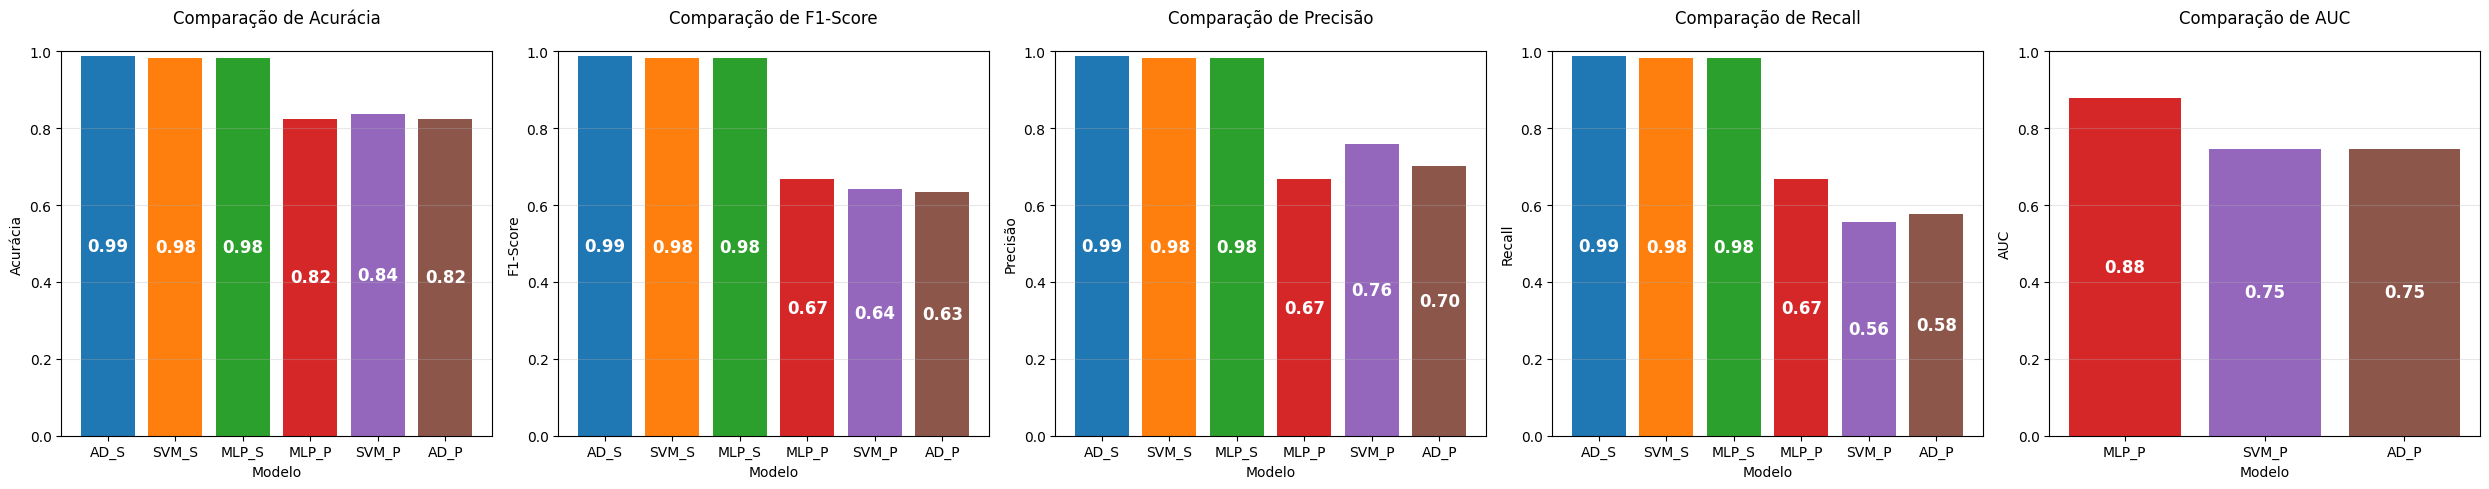

In [127]:
plot_comparacao_resultados(df_resultados)


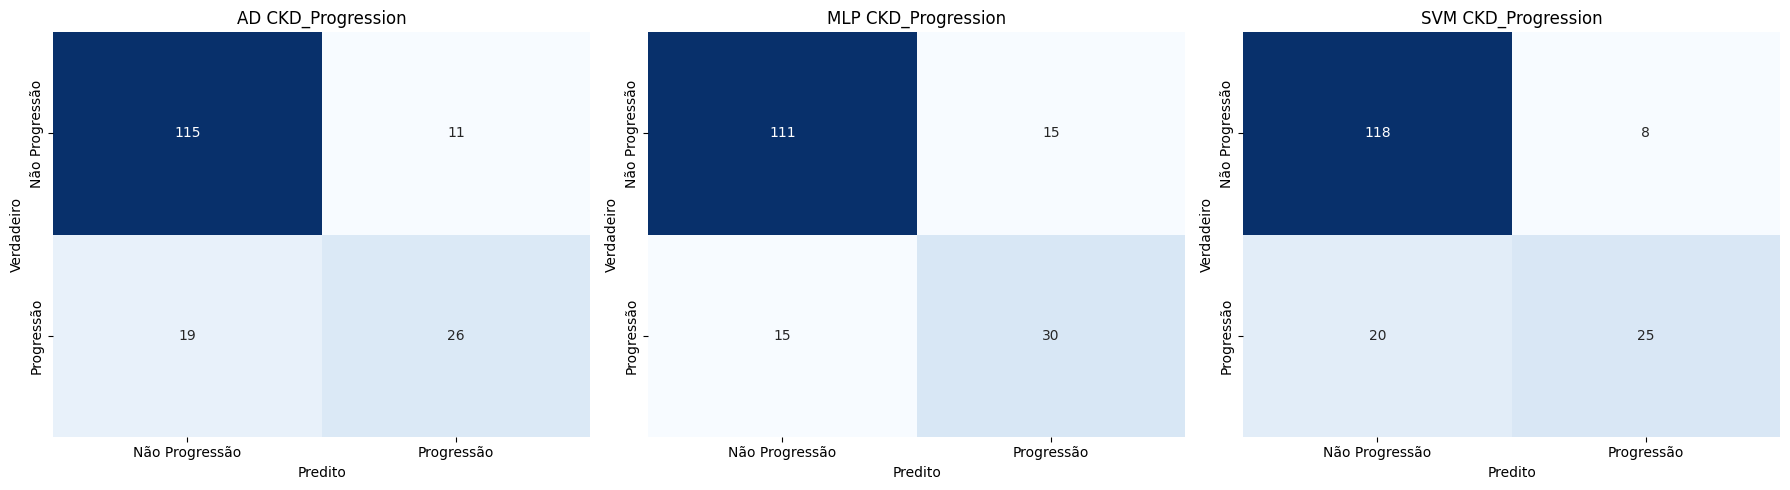

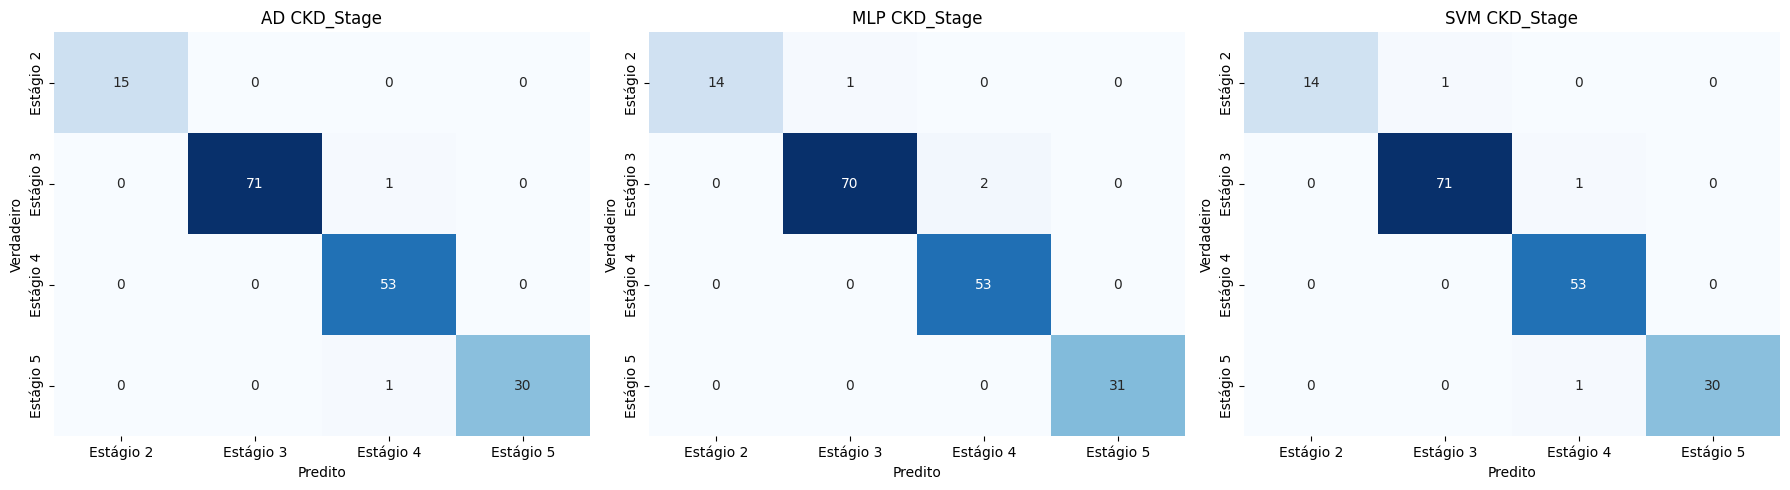

In [128]:
# CKD_Progression (binary)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
cms = [cm_dt, cm_mlp_pg, cm_svm_pg]
titles = ['AD CKD_Progression', 'MLP CKD_Progression', 'SVM CKD_Progression']
for i, (cm, title) in enumerate(zip(cms, titles)):
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
				xticklabels=['Não Progressão', 'Progressão'],
				yticklabels=['Não Progressão', 'Progressão'],
				ax=axes[i])
	axes[i].set_title(title)
	axes[i].set_xlabel('Predito')
	axes[i].set_ylabel('Verdadeiro')
plt.tight_layout()
plt.show()

# CKD_Stage (multiclass)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
cms = [cm_dt_st, cm_mlp_st, cm_svm_st]
titles = ['AD CKD_Stage', 'MLP CKD_Stage', 'SVM CKD_Stage']
stage_labels = ['Estágio 2', 'Estágio 3', 'Estágio 4', 'Estágio 5']
for i, (cm, title) in enumerate(zip(cms, titles)):
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
				xticklabels=stage_labels, yticklabels=stage_labels,
				ax=axes[i])
	axes[i].set_title(title)
	axes[i].set_xlabel('Predito')
	axes[i].set_ylabel('Verdadeiro')
plt.tight_layout()
plt.show()

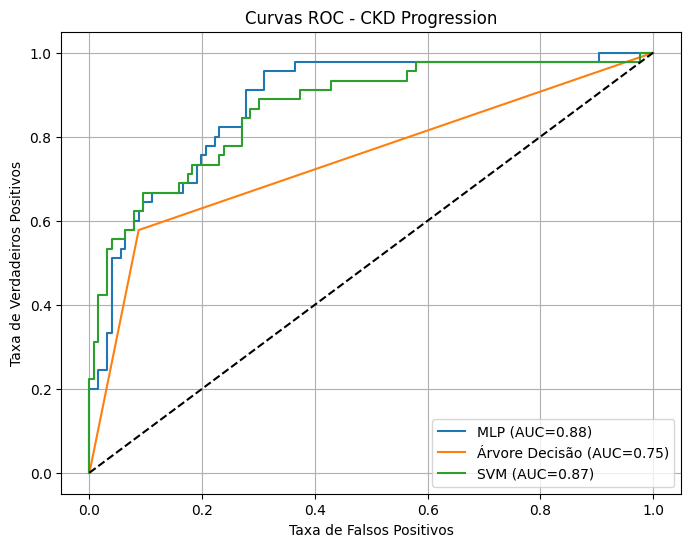

In [129]:
# ROC Curves
plt.figure(figsize=(8, 6))

# MLP
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_pg, y_pred_mlp_prob)
auc_mlp = roc_auc_score(y_test_pg, y_pred_mlp_prob)
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC={auc_mlp:.2f})')

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test_pg, y_test_pred_pg)
auc_dt = roc_auc_score(y_test_pg, y_test_pred_pg)
plt.plot(fpr_dt, tpr_dt, label=f'Árvore Decisão (AUC={auc_dt:.2f})')

# SVM
svm_probs = svm_model.predict_proba(X_test_pg_norm)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test_pg, svm_probs)
auc_svm = roc_auc_score(y_test_pg, svm_probs)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC={auc_svm:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC - CKD Progression')
plt.legend()
plt.grid(True)
plt.show()